# Install module

In [1]:
# @title
!pip install nibabel
!pip install tensorflow
!pip install torchio


# Setting

In [2]:
import os, torch
from pathlib import Path

# 초기 세팅값

# 영상 사이즈 (ex 64, 128 ....)
MRI_SIZE = 128
# 테스트할때 사용할 데이터 수 ( 학습, 증강에서 제외됨 )
TEST_DATA_SIZE = 50
# 사용할 데이터 경로
INPUT_DATASET_PATH="/content/drive/MyDrive/model_source/registered_brains_128/"

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS"] = "1"
torch.set_num_threads(1)

# 캐시 전역 설정 (통일형)
CACHE_ROOT = Path("./cache_preprocessed")
CACHE_VERSION = "pre_v5"      # 버전 문자열 한 곳에서 관리
CACHE_DIR = CACHE_ROOT / CACHE_VERSION
CFG_VERSION = CACHE_VERSION   # TorchIO 파이프라인에서 참조

# ClassModels

In [3]:
# @title
from pathlib import Path
from typing import Optional, Dict, Any
import numpy as np


class Label:
    """
    라벨 클래스

    설명:
        Subject         : 환자 식별 번호
        Group           : 치매 여부  (CN => 0 AD => 1)
        Image Data ID   : 촬영 식별 번호
    """
    def __init__(self, subject: str, group: str, imageDataID: str):
        self.subject = subject
        self.group = group
        self.imageDataID = imageDataID


    def __repr__(self):
        return f"(subject = {self.subject}, group = {self.group}, imageDataID = {self.imageDataID})"


class ClinicalDataset:

    """
    학습을 위한 단일 샘플 클래스

    설명:
        volume (np.ndarray): 3D MRI 볼륨 데이터
        label (Any): 정답 라벨 (예: 'AD', 0, 1 등)
        modalities (Dict[str, Any]): 임상 정보, 유전자 정보 등 다양한 모달 입력
    """

    def __init__(self, volume_path: Path, label: Label, modalities: Optional[Dict[str, Any]] = None):
        self.volume_path = volume_path          # mri 3d 모델 경로(메모리 매핑)
        self.label = label                      # 라벨
        self.modalities = modalities or {}      # mmse, ldkjflskd~~~~


    def load_volume(self):
        """
        경로에 있는 볼륨을 로드
        """
        return np.load(self.volume_path, mmap_mode='r')

    def to_tensor_dict(self):
        """PyTorch나 TensorFlow 학습에 적합한 딕셔너리 형태로 변환"""
        return {
            "mri": self.volume,
            "label": self.label,
            "modalities": self.modalities
        }

    def __repr__(self):
        return f"----\nlabel : {self.label}modalities {self.modalities}\n----\n"


# Util

In [4]:
# @title

import queue
import threading


def ask_yes_no(prompt: str, default: str = 'y',timeout:int = 5) -> bool:
    """
    선택지를 묻는 함수

    INPUT:
        prompt : 물어볼 내용
        default : 공백 입력시 사용할 답안
    OUTPUT:
        bool : 결과
    """


    # 입력 대소문자 통일
    default = default.lower()
    if default not in ['y', 'n']:
        raise ValueError("default must be 'y' or 'n'")

    # 공백시 사용할 답안 처리
    prompt_suffix = "((y)/n)" if default == 'y' else "(y/(n))"
    user_input = queue.Queue()

    def get_input():
        print(f"{prompt} {prompt_suffix}: ", end='', flush=True)
        user_input.put(input().strip().lower())

    # 정상적인 답을 입력할때 까지 입력 요청
    while True:
        thread = threading.Thread(target=get_input)
        thread.start()
        thread.join(timeout)
        if not user_input.empty():
            answer = user_input.get()
            if answer == '':
                return default == 'y'
            elif answer in ['y', 'yes']:
                return True
            elif answer in ['n', 'no']:
                return False
            else:
                print("Please enter y or n.")
        else:
            print(f"\n입력 시간이 초과되어 기본값 '{default}'으로 처리됩니다.")
            return default == 'y'



import os
import time

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import psutil

# from classModels import ClinicalDataset

def timer(label="Timer"):
    """
    이전에 이 힘수를 호출한 시점으로부터 시간을 출력
    INPUT:
        label : 설명
    """
    if not hasattr(timer, "_last_time"):
        timer._last_time = time.time()
        print(f"\n[{label}] 시작\n")
    else:
        now = time.time()
        elapsed = now - timer._last_time
        print(f"\n[{label}] 경과 시간: {elapsed:.2f}초\n")
        timer._last_time = now



def reset_log(file_path="log.txt"):
    """
    로그 파일 초기화 하는 함수
    INPUT:
        file_path: 로그 파일 이름 입력 없을시 기본 log.txt로 작성됨됨

    """
    with open(file_path, "w", encoding="utf-8") as f:
        f.write("")  # 빈 문자열로 덮어쓰기


def print_and_log(text, file_path="log.txt"):
    """
    로그 찍어주는 함수
    INPUT:
        text : 찍을 로그
        file_path : 로그 파일 이름 입력 없을시 기본 log.txt로 작성됨
    """

    text = str(text)
    #print(text)
    with open(file_path, "a", encoding="utf-8") as f:
        f.write(text + "\n")



def test_memory_load(samples:list[ClinicalDataset], verbose=True):
    """
    데이터 메모리 사용량 확인용 코드
    INPUT:
        samples : 테스트할 데이터(list[ClinicalDataset])
        verbose : 중간과정 출력 여부
    OUTPUT:
        X

    """
    volumes = []
    for i, sample in enumerate(samples):
        vol = np.load(sample.volume_path).astype(np.float32)
        volumes.append(vol)
        if verbose and i % 10 == 0:
            print(f"{i+1}개 로드 완료")
    print(f"총 {len(volumes)}개 샘플 메모리에 적재 완료")
    test_volumes = volumes

    process = psutil.Process(os.getpid())
    print(f"현재 메모리 사용량: {process.memory_info().rss / 1024 ** 2:.2f} MB")



def plot_history(history):
    # 정확도 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실값 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_prediction_histogram(labels, predictions, threshold=0.5):
    """
    예측 점수 히스토그램을 시각화합니다.

    Parameters:
    - labels: 실제 정답 (리스트나 배열), 예: ["AD", "CN", ...]
    - predictions: 모델 예측 점수 (0~1 사이), 예: [0.83, 0.41, ...]
    - threshold: 분류 임계값 (기본값은 0.5)
    """
    df = pd.DataFrame({
        "Label": labels,
        "Prediction": predictions
    })

    ad_scores = df[df["Label"] == "AD"]["Prediction"]
    cn_scores = df[df["Label"] == "CN"]["Prediction"]

    plt.figure(figsize=(8, 5))
    plt.hist(ad_scores, bins=20, alpha=0.7, label="AD", color='red')
    plt.hist(cn_scores, bins=20, alpha=0.7, label="CN", color='blue')
    plt.axvline(x=threshold, color='black', linestyle='--', label=f"Threshold = {threshold}")
    plt.title("Prediction Score Histogram")
    plt.xlabel("Prediction Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

def plot_roc_curve(labels, predicts):
    """
    모델 분류 성능 표시 그래프
    좌상단에 그래프가 모일수록 성능 좋음
    """
    y_true = [0 if lbl == "CN" else 1 for lbl in labels]

    fpr, tpr, thresholds = roc_curve(y_true, predicts)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


def plot_all_metrics(history, labels, predictions, threshold=0.5):
    """
    데이터 종합 시각화 방식
    텐서플로우의 history 2개
    roc_curve <- 모델 분류 성능을 표시 -> 좌상단에 그래프가 쏠릴수록 성능 높음
    prediction histogram <- 예측 결과 분포 표시,
    """

    y_true = [0 if lbl == "CN" else 1 for lbl in labels]
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr,
                  tpr)
    labels = np.ravel(labels)
    predictions = np.ravel(predictions)

    df = pd.DataFrame({"Label": labels, "Prediction": predictions})
    ad_scores = df[df["Label"] == "AD"]["Prediction"]
    cn_scores = df[df["Label"] == "CN"]["Prediction"]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # 텐서 플로우 학습 epoch별로 정확도 그래프
    axs[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axs[0, 0].set_title('Accuracy over Epochs')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()

    # 텐서 플로우 학습 epoch별로 손실 그래프
    axs[0, 1].plot(history.history['loss'], label='Train Loss')
    axs[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axs[0, 1].set_title('Loss over Epochs')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # ROC Curve
    axs[1, 0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axs[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1, 0].set_xlabel('False Positive Rate')
    axs[1, 0].set_ylabel('True Positive Rate')
    axs[1, 0].set_title('ROC Curve')
    axs[1, 0].legend(loc='lower right')

    # 예측값 분포 그래프
    axs[1, 1].hist(ad_scores, bins=20, alpha=0.7, label="AD", color='red')
    axs[1, 1].hist(cn_scores, bins=20, alpha=0.7, label="CN", color='blue')
    axs[1, 1].axvline(x=threshold, color='black', linestyle='--', label=f"Threshold = {threshold}")
    axs[1, 1].set_title("Prediction Score Histogram")
    axs[1, 1].set_xlabel("Prediction Score")
    axs[1, 1].set_ylabel("Frequency")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


# Loader

In [5]:
# @title
from functools import partial
import subprocess
import concurrent
import numpy as np
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt
import gc
from typing import Optional, Dict, Any
from matplotlib.widgets import Slider
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import zoom
# from classModels import Label
# from util import *
from scipy.ndimage import zoom
import glob


import subprocess
from pathlib import Path




def convert_dcm_to_nii(dicom_dir:Path, output_dir:Path):
    """
    dcm파일을 nii로 변환하는 프로세스

    INPUT:
        dicom_dir(Path) : dcm파일이 있는 경로
        output_dir(Path) : 완성된 nii파일이 저장될 공간
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    LOADER_DIR = Path(__file__).resolve().parent
    dcm2niixLink = LOADER_DIR/"TOOL"/"dcm2niix.exe"

    command = [
        str(dcm2niixLink),
        "-z", "y",
        "-o", str(output_dir),
        str(dicom_dir)
    ]
    result = subprocess.run(command,capture_output=True, text=True)

    if result.returncode == 0:

        # print("변환 성공 :\n",result.stdout)
        pass
    else:
        print("변환 실패 :\n",result.stderr)


def load_nii_volume(nii_path:Path):
    """
    nii 또는 .nii.gz파일의 volume을 로드

    INTPUT:
        nii_path    : .nii또는 .nii.gz파일 경로
    OUTPUT:
        volume      : 3차원 영상?
    """
    gc.collect()
    img = nib.load(nii_path)
    data = img.get_fdata().astype(np.float32)

    file_name = nii_path.name
    ID = file_name.split("_")[0]
    # 1. 확장자 제거 (.nii.gz)
    if file_name.endswith(".nii.gz"):
        file_name = file_name.removesuffix(".nii.gz")

    # 2. '_' 포함 여부에 따른 ID 추출
    if "_" in file_name:
        ID = file_name.split("_")[0]
    else:
        ID = file_name  # '_'가 없으면 전체를 ID로 사용



    return data, ID

def view_nii(nii_path:Path):
    """
    한개의 nii파일을 보는 함수
    INTPUT:
        nii_path            : .nii또는 .nii.gz파일 경로


    """

    img = nib.load(nii_path)
    data = img.get_fdata()

    # 초기 슬라이스 인덱스
    x, y, z = data.shape
    idxs = [x // 2, y // 2, z // 2]

    # Figure & Subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.subplots_adjust(bottom=0.25)

    im0 = axes[0].imshow(data[idxs[0], :, :].T, cmap="gray", origin="lower")
    axes[0].set_title("Sagittal (X)")
    im1 = axes[1].imshow(data[:, idxs[1], :].T, cmap="gray", origin="lower")
    axes[1].set_title("Coronal (Y)")
    im2 = axes[2].imshow(data[:, :, idxs[2]].T, cmap="gray", origin="lower")
    axes[2].set_title("Axial (Z)")

    for ax in axes:
        ax.axis("off")

    # 슬라이더 위치 정의
    axcolor = 'lightgoldenrodyellow'
    ax_x = plt.axes([0.15, 0.15, 0.7, 0.03], facecolor=axcolor)
    ax_y = plt.axes([0.15, 0.10, 0.7, 0.03], facecolor=axcolor)
    ax_z = plt.axes([0.15, 0.05, 0.7, 0.03], facecolor=axcolor)

    slider_x = Slider(ax_x, 'X-axis', 0, x - 1e-3, valinit=idxs[0], valstep=1)
    slider_y = Slider(ax_y, 'Y-axis', 0, y - 1e-3, valinit=idxs[1], valstep=1)
    slider_z = Slider(ax_z, 'Z-axis', 0, z - 1e-3, valinit=idxs[2], valstep=1)

    # 슬라이더 업데이트 함수
    def update(val):
        ix = int(slider_x.val)
        iy = int(slider_y.val)
        iz = int(slider_z.val)

        im0.set_data(data[ix, :, :].T)
        im1.set_data(data[:, iy, :].T)
        im2.set_data(data[:, :, iz].T)
        fig.canvas.draw_idle()

    # 슬라이더 이벤트 연결
    slider_x.on_changed(update)
    slider_y.on_changed(update)
    slider_z.on_changed(update)

    plt.show()

def view_volume(volume:np.ndarray):
    """
    한개의 volume을 보는 함수
    INTPUT:
        volume            : nii로 부터 가져온 volume


    """


    data = volume

    # 초기 슬라이스 인덱스
    x, y, z = data.shape
    idxs = [x // 2, y // 2, z // 2]

    # Figure & Subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.subplots_adjust(bottom=0.25)

    im0 = axes[0].imshow(data[idxs[0], :, :].T, cmap="gray", origin="lower")
    axes[0].set_title("Sagittal (X)")
    im1 = axes[1].imshow(data[:, idxs[1], :].T, cmap="gray", origin="lower")
    axes[1].set_title("Coronal (Y)")
    im2 = axes[2].imshow(data[:, :, idxs[2]].T, cmap="gray", origin="lower")
    axes[2].set_title("Axial (Z)")

    for ax in axes:
        ax.axis("off")

    # 슬라이더 위치 정의
    axcolor = 'lightgoldenrodyellow'
    ax_x = plt.axes([0.15, 0.15, 0.7, 0.03], facecolor=axcolor)
    ax_y = plt.axes([0.15, 0.10, 0.7, 0.03], facecolor=axcolor)
    ax_z = plt.axes([0.15, 0.05, 0.7, 0.03], facecolor=axcolor)

    slider_x = Slider(ax_x, 'X-axis', 0, x - 1e-3, valinit=idxs[0], valstep=1)
    slider_y = Slider(ax_y, 'Y-axis', 0, y - 1e-3, valinit=idxs[1], valstep=1)
    slider_z = Slider(ax_z, 'Z-axis', 0, z - 1e-3, valinit=idxs[2], valstep=1)

    # 슬라이더 업데이트 함수
    def update(val):
        ix = int(slider_x.val)
        iy = int(slider_y.val)
        iz = int(slider_z.val)

        im0.set_data(data[ix, :, :].T)
        im1.set_data(data[:, iy, :].T)
        im2.set_data(data[:, :, iz].T)
        fig.canvas.draw_idle()

    # 슬라이더 이벤트 연결
    slider_x.on_changed(update)
    slider_y.on_changed(update)
    slider_z.on_changed(update)

    plt.show()



def load_dcm_to_nii(input_dataset_path):
    """
    기본적인 원본 mri를 가져오는 함수

    dcm을 로드해서 nii로 저장하는 과정을 진행

    """

    # INPUT_DATASET
    #   test (1)                                다운로드 받은 콜랙션 이름
    #       ADNI                                ADNI
    #           002_S_0295                      Subject --> 환자 식별 변호
    #               MPRAGE                      촬영 방식
    #                   2012-05-10_15_44_50.0   촬영 날짜 (여러개 존재 가능)
    #                       I303066             Image Data ID --> 촬영 식별번호

    _path = input_dataset_path

    collections = [f.name for f in input_dataset_path.iterdir() if f.is_dir()]

    mri_count = 0

    convert_targets = []

    for collection in collections:
        _collectionPath = _path
        _path = _path / collection / 'ADNI'
        subjects = [f.name for f in _path.iterdir() if f.is_dir()]

        for subject in subjects:
            _subjectPath = _path
            _path = _path / subject / 'MPRAGE'
            acqDates = [f.name for f in _path.iterdir() if f.is_dir()]

            for acqDate in acqDates:
                _acqDatePath = _path
                _path = _path / acqDate
                imageDataIDs = [f.name for f in _path.iterdir() if f.is_dir()]

                for imageDataID in imageDataIDs:
                    _imageDataIDPath = _path
                    dcm_path = _path / imageDataID
                    convert_targets.append(dcm_path)
                    _path = _imageDataIDPath

                _path = _acqDatePath
            _path = _subjectPath
        _path = _collectionPath

    for idx, dcm_path in enumerate(tqdm(convert_targets, desc="dcm → nii 변환")):
        convert_dcm_to_nii(dcm_path, input_dataset_path)



    print(f"확인된 mri 개수 : {mri_count}")



def load_labels(input_dataset_path):
    """
    데이터의 정답을 가져오는 함수

    INPUT
        사용할 라벨 이름(vector)
    OUTPUT
        ex) 나이(vector), 성별(vector)...
    """

    # INPUT_DATASET 폴더속 csv확장자 모두 로드
    input_path = Path(input_dataset_path) # Ensure input_dataset_path is a Path object
    csv_files = list(input_path.glob("*.csv"))
    # 그중 첫번째 csv파일을 사용
    df = pd.read_csv(csv_files[0])
    df = df[['Subject','Group','Image Data ID']]
    labels = [Label(subject, group, imageID)
              for subject, group, imageID in zip(df['Subject'],df['Group'],df['Image Data ID'])]

    return labels

def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    3D MRI 볼륨을 target_shape로 리사이즈함

    Args:
        volume (np.ndarray): 원본 MRI 볼륨 (D, H, W)
        target_shape (tuple): 원하는 출력 크기 (D, H, W)

    Returns:
        np.ndarray: 리사이즈된 MRI 볼륨
    """
    zoom_factors = [t / s for t, s in zip(target_shape, volume.shape)]
    resized = zoom(volume, zoom=zoom_factors, order=1)  # 선형 보간
    return resized.astype(np.float32)

def load_resample_volume(nii_path:Path, target_spacing=(1.0, 1.0, 1.0)):
    """
    NIfTI 파일을 로드하고, 지정된 voxel spacing으로 리샘플링한 3D 볼륨과 ID 반환

    INPUT:
        nii_path (Path): 입력 .nii 또는 .nii.gz 파일 경로
        target_spacing (tuple): 원하는 spacing (단위: mm)

    OUTPUT:
        np.ndarray: 리샘플링된 3D 볼륨 (float32)
        str: 파일명 기반 ID
    """
    gc.collect()
    img = nib.load(nii_path)    # 이미지 로드
    file_name = nii_path.name
    ID = file_name.split("_")[0]    # 파일 이름에서 ID추출
    # 1. 확장자 제거 (.nii.gz)
    if file_name.endswith(".nii.gz"):
        file_name = file_name.removesuffix(".nii.gz")

    # 2. '_' 포함 여부에 따른 ID 추출
    if "_" in file_name:
        ID = file_name.split("_")[0]
    else:
        ID = file_name  # '_'가 없으면 전체를 ID로 사용


    # nii파일의 affine 행렬(voxel의 간격) 추출
    original_spacing = np.abs(img.affine[:3,:3].diagonal())
    # 복셀 비율을 정육면체 형태로 변환할 비율 계산
    zoom_factors = original_spacing/np.array(target_spacing)
    # 데이터 로드
    data = img.get_fdata()
    # 비율 조정
    resampled_data = zoom(data, zoom=zoom_factors, order=1)

    # new_affine = np.copy(img.affine)
    # new_affine[:3,:3] = np.diag(target_spacing)



    return resampled_data.astype(np.float32), ID



def loader(dcm_to_nii_process:bool, size:int):
    """
    모든 기본 데이터를 갖춘 벡터를 리턴합니다.

    INPUT:
        dcm_to_nii_process : dcm파일을 nii파일로 변환을 진행여부

    OUTPUT:
        ClinicalDataset 리스트 혹은 벡터?
    """
    timer("초기 데이터 로드 시작")


    # 루트 경로 지정
    # ROOT_DIR = Path(__file__).resolve().parent.parent

    # INPUT_DATASET 폴더로 주소 이동
    # input_dataset_path = ROOT_DIR/"INPUT_DATASET"
    input_dataset_path = "/content/drive/MyDrive/hd_bet/"
    # input_dataset_path = "/content/drive/MyDrive/hip_only_mri/"
    labels = load_labels(input_dataset_path)


    # dcm 파일을 nii로 변환
    if(dcm_to_nii_process==True):
        timer("dcm파일 nii로 변환 시작")
        load_dcm_to_nii(input_dataset_path)
        timer("dcm파일 nii로 변환 완료")
        # timer("HD-BET 적용 시작")
        # runing_hd_bet(input_dataset_path)
        # timer("HD-BET 적용 완료")


    # INPUT_DATASET에 있는 모든 .nii.gz의 이름 저장
    nii_list = sorted(Path(input_dataset_path).glob("*.nii.gz"))

    # view_nii(nii_list[0])

    # 가져온 mri영상의 3차원 배열 목록
    # volumes, IDs = zip(*[load_nii_volume(i) for i in tqdm(nii_list, desc="NIfTI 로딩 중")])



    # 메모리 매핑
    num_sample = len(nii_list)
    example_volume, _ = load_nii_volume(nii_list[0])
    example_volume = resize_volume(example_volume, target_shape=(size, size, size))
    example_volume = np.expand_dims(example_volume, axis=-1)


    shape = example_volume.shape

    data_path = "volumes_memmap.dat"
    volumes = np.memmap(data_path, dtype=np.float32, mode='w+', shape=(num_sample, *shape))

    volume_paths = []

    save_dir = Path("volumes")
    save_dir.mkdir(parents=True, exist_ok=True)


    # 데이터 로드
    IDs =[]
    for idx, path in enumerate(tqdm(nii_list,desc="NIFTI 로딩 중")):
        volume, ID = load_nii_volume(path)

        volume = resize_volume(volume, target_shape=(size, size, size))
        volume = np.expand_dims(volume, axis=-1)

        file_path = Path("volumes")/f"{ID}.npy"
        np.save(file_path, volume)
        volume_paths.append(file_path)


        volumes[idx] = volume
        IDs.append(ID)

    volumes.flush()

    # 메모리 매핑 쓰기 모드 종료

    # 메모리 매핑 읽기 모드로 실행
    # volumes = np.memmap(data_path, dtype=np.float32, mode='r', shape=(num_sample, *shape))




    clinicalDataset = []

    # imageDataID를 기준으로 labels 딕셔너리 생성
    dict_labels = {label.imageDataID: label for label in labels}

    # IDs 순서대로 정렬된 labels 생성
    sorted_labels = [dict_labels[i] for i in IDs]

    # 모든 mri 영상 및 라벨 로드



    for i in tqdm(range(len(IDs)), desc="MRI 및 라벨 로딩 중"):
        volume_path = volume_paths[i]
        p = ClinicalDataset(volume_path,sorted_labels[i])
        clinicalDataset.append(p)



    timer("초기 데이터 로드 완료")
    return clinicalDataset


#multy processing
#기본 로드 함수
def load_and_process_nii_mp(nii_path_str: str, size: int, save_dir_str: str):
    nii_path = Path(nii_path_str)
    save_dir = Path(save_dir_str)

    # volume, ID = load_nii_volume(nii_path)
    volume, ID = load_resample_volume(nii_path)
    volume = resize_volume(volume, target_shape=(size, size, size))
    volume = np.expand_dims(volume, axis=-1)
    volume = volume.astype(np.float32) # 볼륨크기 조정-wmc

    file_path = save_dir / f"{ID}.npy"
    np.save(file_path, volume)

    return volume.astype(np.float32), ID, Path(str(file_path)) # 쒸발 이거 str아니에요 Path형 자료에요 -wmc

def load_and_process_wrapper(args):
        nii_path_str, size, save_dir_str = args
        return load_and_process_nii_mp(nii_path_str, size, save_dir_str)

def loader_parallel_process(dcm_to_nii_process: bool, size: int, max_workers: int = 8):
    """
    NIfTI 파일 로드, 전처리, 저장 과정을 멀티프로세싱으로 병렬화한 로더 함수입니다.

    INPUT
    dcm_to_nii_process: DICOM 파일을 NIfTI(.nii.gz)로 진행여부
    size: 볼륨 리사이즈 시의 목표 크기 (size x size x size).
    max_workers: 사용할 병렬 처리 프로세스 수. 기본값은 CPU 코어 수. 그냥 넣지 말고 기본값 쓰셈

    OUTPUT
    ClinicalDataset 인스턴스들의 리스트.
    """

    # 루트 경로 지정

    # ROOT_DIR = Path(__file__).resolve().parent.parent

    # INPUT_DATASET 폴더로 주소 이동
    # input_dataset_path = ROOT_DIR / "INPUT_DATASET"
    input_dataset_path = "/content/drive/MyDrive/hd_bet/"
    # input_dataset_path = "/content/drive/MyDrive/hip_only_mri/"
    labels = load_labels(input_dataset_path)

    # dcm 파일을 nii로 변환
    if dcm_to_nii_process:
        timer("dcm파일 nii로 변환 시작")
        load_dcm_to_nii(input_dataset_path)
        timer("dcm파일 nii로 변환 완료")

    # INPUT_DATASET에 있는 모든 .nii.gz의 이름 저장
    nii_list = sorted(Path(input_dataset_path).glob("*.nii.gz"))



    # 메모리 매핑
    num_sample = len(nii_list)
    example_volume, _ = load_nii_volume(nii_list[0])
    example_volume = resize_volume(example_volume, target_shape=(size, size, size))
    example_volume = np.expand_dims(example_volume, axis=-1)
    example_volume = example_volume.astype(np.float32) # 64->32로 수정 - wmc
    shape = example_volume.shape

    data_path = "volumes_memmap.dat"
    volumes = np.memmap(data_path, dtype=np.float32, mode='w+', shape=(num_sample, *shape))

    save_dir = Path("volumes")
    save_dir.mkdir(parents=True, exist_ok=True)

    #이건 병렬 프로세싱에 쓸 함수 만들기
    # func = partial(load_and_process_nii_mp, size=size, save_dir_str=str(save_dir))


    nii_path_strs = [str(p) for p in nii_list]

    clinicalDataset = []
    volume_paths = []
    IDs = []
    #여기서 병렬 프로세싱
    args_list = [(p, size, str(save_dir)) for p in nii_path_strs]
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(load_and_process_wrapper, args_list),
            total=num_sample,
            desc="NIFTI 멀티프로세싱 처리 중"
        ))

    for idx, (volume, ID, file_path) in enumerate(results):
        volumes[idx] = volume
        IDs.append(ID)
        volume_paths.append(file_path)

    volumes.flush()
    volumes = np.memmap(data_path, dtype=np.float32, mode='r', shape=(num_sample, *shape))

    dict_labels = {label.imageDataID: label for label in labels}
    sorted_labels = [dict_labels[i] for i in IDs]

    for i in tqdm(range(num_sample), desc="MRI 및 라벨 로딩 중"):
        p = ClinicalDataset(volume_paths[i], sorted_labels[i])
        clinicalDataset.append(p)

    timer("초기 데이터 로드 완료")
    return clinicalDataset

# Loader(improved)

해당 영역에서 해야할것?

입력:
  특정 mri 영상(only hipo or brain)
  나이, 성별, (mmse, cdr)

출력:
  clinicaldata list

In [6]:
# @title
# -*- coding: utf-8 -*-
# TorchIO + ClinicalDataset 병렬 로더 (고정 증강 + 캐시 + 매니페스트)
# 의존: 같은 노트북/모듈 내에 ClinicalDataset, Label 클래스가 이미 정의되어 있어야 함.

import os, gc, json, hashlib, random
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
import torch
import torchio as tio
from tqdm.notebook import tqdm  # Changed tqdm to tqdm.notebook.tqdm
import pandas as pd

# ====== 전역 설정 ======
MANIFEST   = CACHE_DIR / "manifest.json"
DEFAULT_TARGET_SPACING = (1.0, 1.0, 1.0)

# ====== 유틸 ======
def _nii_id_from_path(nii_path: Path) -> str:
    name = nii_path.name
    base = name[:-7] if name.endswith(".nii.gz") else nii_path.stem
    return base.split("_")[0]

import torch.nn.functional as F

def _resample_and_resize_gpu(volume_np: np.ndarray,
                             spacing_xyz: np.ndarray,
                             target_spacing=(1.0,1.0,1.0),
                             out_shape=(128,128,128)) -> np.ndarray:
    # numpy -> torch CUDA 텐서 [1,1,D,H,W]
    t = torch.from_numpy(volume_np).to(torch.float32).unsqueeze(0).unsqueeze(0).cuda()

    # spacing 보정: new = input * (spacing / target_spacing)
    zoom = spacing_xyz / np.array(target_spacing, dtype=np.float32)
    D, H, W = t.shape[-3:]
    newD = int(round(D * float(zoom[2])))
    newH = int(round(H * float(zoom[1])))
    newW = int(round(W * float(zoom[0])))

    # 1) 리샘플(등방/타깃 spacing)  2) 최종 네트워크 입력 크기
    t = F.interpolate(t, size=(newD, newH, newW), mode="trilinear", align_corners=False)
    t = F.interpolate(t, size=out_shape,            mode="trilinear", align_corners=False)

    out = t.squeeze(0).squeeze(0).cpu().numpy().astype(np.float32)
    return out

def _load_resample_resize_gpu(nii_path: Path,
                              target_spacing=DEFAULT_TARGET_SPACING,
                              out_shape=(128,128,128)) -> np.ndarray:
    img = nib.load(str(nii_path))
    vol = img.get_fdata().astype(np.float32)                     # CPU
    spacing = np.abs(img.affine[:3, :3].diagonal()).astype(np.float32)  # [sx, sy, sz]
    return _resample_and_resize_gpu(vol, spacing, target_spacing, out_shape)


import torch

def _tio_apply(volume: np.ndarray, transform: tio.Transform | None) -> np.ndarray:
    # TorchIO는 CPU에서만 안정적으로 동작(SITK/NumPy 경로)
    subject = tio.Subject(image=tio.ScalarImage(tensor=volume[np.newaxis]))
    if transform is not None:
        subject = transform(subject)
    return subject.image.data[0].numpy()



def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

def make_seed(subject_id: str, aug_idx: int, base_seed: int = 20241108) -> int:
    h = hashlib.sha1(f"{subject_id}-{aug_idx}-{base_seed}".encode()).hexdigest()[:8]
    return int(h, 16)

def _fixed_transform():
    return tio.Compose([
        tio.RandomAffine(scales=(0.97, 1.03), degrees=3, translation=1, p=1.0),
        tio.RandomElasticDeformation(
            num_control_points=(5, 5, 5),   # >=4
            max_displacement=1.0,          # 1.0~1.5 권장
            locked_borders=2,
            p=0.7                           # 확률 완화로 평균 연산량 절감
        ),
        tio.RandomNoise(mean=0, std=0.02, p=0.5),
        tio.RandomBiasField(coefficients=0.12, p=0.3),
    ])


def _cache_path(subject_id: str, size: int, aug_idx: int, seed: int) -> Path:
    # 0은 원본 전처리본, 1..N은 증강본
    subdir = CACHE_DIR / subject_id / f"{CFG_VERSION}_sz{size}"
    name = f"{subject_id}__aug{aug_idx:02d}_s{seed:08x}.npy"
    return subdir / name

def _atomic_save_npy(final_path: Path, arr: np.ndarray):
    final_path.parent.mkdir(parents=True, exist_ok=True)
    tmp = final_path.with_suffix(final_path.suffix + ".tmp")  # 예: foo.npy.tmp
    # np.save가 이름을 바꾸지 못하도록 파일 핸들에 씁니다.
    with open(tmp, "wb") as f:
        np.save(f, arr, allow_pickle=False)
        f.flush()
        os.fsync(f.fileno())
    os.replace(tmp, final_path)  # 원자적 치환

def _load_manifest() -> dict:
    if MANIFEST.exists():
        return json.loads(MANIFEST.read_text())
    return {}

def _save_manifest(m: dict):
    MANIFEST.parent.mkdir(parents=True, exist_ok=True)
    MANIFEST.write_text(json.dumps(m, indent=2))

# ====== 라벨 로딩 ======
def load_labels_from_csv(input_dataset_path: str) -> list:
    input_path = Path(input_dataset_path)
    csv_files = list(input_path.glob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("라벨 CSV를 찾을 수 없습니다 (예: *.csv).")
    df = pd.read_csv(csv_files[0])
    labels = [Label(subject, group, image_id)
              for subject, group, image_id in zip(df["Subject"], df["Group"], df["Image Data ID"])]
    return labels

# ====== 워커 ======
def _process_one_nii(
    nii_path_str: str,
    size: int,
    target_spacing=DEFAULT_TARGET_SPACING,
    do_augment: bool = False,
    aug_index: int = 0,
) -> tuple[str, str]:
    """
    리샘플(등방 1mm) -> (선택)고정증강 -> 리사이즈(size^3) -> 채널추가 -> 캐시 저장 -> (ID, 경로) 반환
    """
    nii_path = Path(nii_path_str)
    subject_id = _nii_id_from_path(nii_path)
    seed = make_seed(subject_id, aug_index)
    set_all_seeds(seed)

    out_path = _cache_path(subject_id, size, aug_index, seed)
    if out_path.exists():
        return subject_id, str(out_path)

    # (GPU) 등방 리샘플 + 최종 리사이즈를 한 번에
    vol = _load_resample_resize_gpu(nii_path, target_spacing, (size, size, size))

    # (CPU) TorchIO 증강 — Subject를 GPU로 올리지 말 것
    if do_augment:
        vol = _tio_apply(vol, _fixed_transform())

    # 채널 차원 추가 및 dtype 고정
    vol = np.expand_dims(vol, axis=-1).astype(np.float32)


    _atomic_save_npy(out_path, vol)
    return subject_id, str(out_path)

def _safe_worker(args):
    try:
        return _process_one_nii(*args)
    except Exception as e:
        import traceback
        tb = traceback.format_exc()
        return {"__error__": True, "msg": str(e), "tb": tb}

# ====== 메인 로더 ======
def loader_torchio_parallel_clinical(
    input_dataset_path: str,
    size: int,
    max_workers: int = 12,
    include_original: bool = True,
    n_aug: int = 0,
    target_spacing=DEFAULT_TARGET_SPACING,
    test_per_class: int = 0,
) -> list:
    """
    - 원본 1개(+include_original) + 고정 증강 n_aug개를 생성해 캐시에 저장
    - ClinicalDataset(Path(npy), Label) 리스트로 반환
    """
    input_path = Path(input_dataset_path)
    nii_list = sorted(input_path.glob("*.nii.gz"))
    if not nii_list:
        print(input_dataset_path)
        raise FileNotFoundError("*.nii.gz 파일을 찾을 수 없습니다.")

    labels = load_labels_from_csv(input_dataset_path)
    label_by_image_id = {lab.imageDataID: lab for lab in labels}

    # 테스트 데이터 분리
    test_ids = set()
    if test_per_class > 0:
      group_to_ids = {
          "AD": [], #치매
          "CN": [], #정
      }
      for lab in labels:
        g = lab.group
        if g in group_to_ids:
          group_to_ids[g].append(lab.imageDataID)
      rng = random.Random(20241108)

      for g, id_list in group_to_ids.items():
          if not id_list:
              continue
          k = min(test_per_class, len(id_list))
          chosen = rng.sample(id_list, k)
          test_ids.update(chosen)

      print(f"[TEST SPLIT] per-class={test_per_class}, AD={len(group_to_ids['AD'])}, "
            f"CN={len(group_to_ids['CN'])}, picked={len(test_ids)}")

    # 매니페스트 로드
    manifest = _load_manifest()

    # 작업 큐 구성(없는 것만)
    jobs = []
    for p in nii_list:
        sid = _nii_id_from_path(p)
        is_test = sid in test_ids

        # 원본
        if include_original:
            seed0 = make_seed(sid, 0)
            p0 = _cache_path(sid, size, 0, seed0)
            if not p0.exists():
                jobs.append((str(p), size, target_spacing, False, 0))
        # 증강
        if not is_test:
          for k in range(1, n_aug + 1):
              seedk = make_seed(sid, k)
              pk = _cache_path(sid, size, k, seedk)
              if not pk.exists():
                  jobs.append((str(p), size, target_spacing, True, k))

    # 병렬 실행 또는 단일 프로세스 실행 (CUDA 사용 시)
    results = []
    if jobs:
        # Check if CUDA is available and if so, disable multiprocessing for this step
        if torch.cuda.is_available():
            print("[CUDA] CUDA 사용 가능 감지. TorchIO 처리는 단일 프로세스로 실행됩니다.")
            for job_args in tqdm(jobs, desc="TorchIO 단일 프로세스 처리 중"):
                r = _safe_worker(job_args)
                if isinstance(r, dict) and r.get("__error__"):
                    print(r["tb"])
                    raise RuntimeError(r["msg"])
                results.append(r)
        else:
            print("[CUDA] CUDA 사용 불가. TorchIO 처리는 멀티프로세스로 실행됩니다.")
            with ProcessPoolExecutor(max_workers=max_workers) as ex:
                it = iter(jobs)
                futs = []
                # 초기 in-flight 채우기
                for _ in range(min(max_workers, len(jobs))):
                    futs.append(ex.submit(_safe_worker, next(it)))

                pbar = tqdm(total=len(jobs), desc="TorchIO 병렬 로딩/고정증강")
                while futs:
                    done = futs.pop(0)
                    r = done.result()
                    if isinstance(r, dict) and r.get("__error__"):
                        print(r["tb"])
                        raise RuntimeError(r["msg"])
                    results.append(r)
                    pbar.update(1)
                    # 하나 끝났으면 하나 제출 → in-flight 유지
                    try:
                        futs.append(ex.submit(_safe_worker, next(it)))
                    except StopIteration:
                        pass
                pbar.close()

    # 캐시 경로를 전부 모아 ClinicalDataset 구성
    datasets = []
    test_datasets = []
    missing_label_ids = []

    def _collect_one(sid: str, aug_idx: int):
        seed = make_seed(sid, aug_idx)
        npy = _cache_path(sid, size, aug_idx, seed)
        if npy.exists():
            lab = label_by_image_id.get(sid)
            if lab is None:
                missing_label_ids.append(sid)
                return
            if sid in test_ids:
              if aug_idx == 0:
                test_datasets.append(ClinicalDataset(npy, lab))
            else:
              datasets.append(ClinicalDataset(npy, lab))

            # 매니페스트 기록
            manifest.setdefault(sid, {}).setdefault(f"sz{size}", []).append(str(npy))

    for p in nii_list:
        sid = _nii_id_from_path(p)
        if include_original:
            _collect_one(sid, 0)
        for k in range(1, n_aug + 1):
            _collect_one(sid, k)

    _save_manifest(manifest)

    if missing_label_ids:
        uniq = sorted(set(missing_label_ids))
        print(f"[경고] 라벨 CSV에 매칭되지 않은 ID {len(uniq)}개: {uniq[:8]} ...")

    return datasets, test_datasets

import shutil

def sync_cache_to_gdrive(gdrive_dir: str):
    """
    로컬 /content 캐시를 GDrive로 한 번에 복사.
    gdrive_dir 예: '/content/drive/MyDrive/volumes_torchio_fixed'
    """
    src = CACHE_DIR
    dst = Path(gdrive_dir)
    dst.parent.mkdir(parents=True, exist_ok=True)
    # 이미 있으면 덮어쓰기: 폴더 단위 복사
    if dst.exists():
        # 부분 업데이트를 원하면 파일 단위 비교 로직을 넣어도 됨.
        shutil.rmtree(dst)
    shutil.copytree(src, dst)
    print(f"[동기화] {src} → {dst} 완료")

# Preprocess

In [7]:
# @title

import gc
import numpy as np
from scipy.ndimage import zoom
#from classModels import *
from tqdm import tqdm
#from util import *







def normalization(volume, clip_percentile=0.2, replace_value=None):
    lower_bound = np.percentile(volume, clip_percentile)
    mask = volume > lower_bound

    mean = np.mean(volume[mask])
    std = np.std(volume[mask])
    std = max(std, 1e-6)

    volume[mask] = (volume[mask] - mean) / std
    if replace_value is None:
        replace_value = np.min(volume[mask])
    volume[~mask] = replace_value
    return volume

def preprocess(origin_data: list[ClinicalDataset], size: int) -> list[ClinicalDataset]:
    """
    전처리를 진행
    INPUT:
        loader()을 통해 출력된 origin_data (ClinicalDataset 리스트)
    OUTPUT:
        전처리된 ClinicalDataset 리스트
    """
    timer("전처리 시작")

    for sample in tqdm(origin_data, desc="정규화 진행 중"):
        volume = sample.load_volume()
        volume = volume.copy() # Create a writable copy

        volume = normalization(volume)

        volume[np.abs(volume) < 0.2] = 0



        # 정규화된 볼륨 저장
        save_path = sample.volume_path.parent / f"normalized_{sample.volume_path.name}"
        np.save(save_path, volume.astype(np.float32))

        # 경로 업데이트
        sample.volume_path = save_path

    timer("전처리 완료")
    return origin_data

# Model

In [25]:
# @title
import random
import numpy as np
# from classModels import ClinicalDataset
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers, Input, Model

from sklearn.model_selection import train_test_split,StratifiedKFold
from tqdm.keras import TqdmCallback

from tensorflow.keras.callbacks import EarlyStopping


# from util import *





def label_to_int(group: str) -> int:
    """
    tensorflow에서 사용하기 위해선 숫자를 이용해서 처리해야함
    그래서 group은 'CN', 'AD'인 문자열을 사용하기에 매핑한것
    """
    return {'CN': 0, 'AD': 1}[group]  # 예시

# ResNet 블록 정의
def resnet_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False):
    x = layers.Conv3D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters, kernel_size, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if conv_shortcut:
        shortcut = layers.Conv3D(filters, 1, strides=stride, use_bias=False)(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def build_model(size: int) -> Model:
    """
    ResNet 모델 구성
    """
    mri_input = Input(shape=(size, size, size, 1), name='mri_input')

    # 초기 컨볼루션 및 풀링
    x = layers.Conv3D(16, 7, strides=2, padding='same', use_bias=False)(mri_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool3D(3, strides=2, padding='same')(x)

    # ResNet 블록들
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)

    x = resnet_block(x, 32, stride=2, conv_shortcut=True)
    x = resnet_block(x, 32)

    x = resnet_block(x, 64, stride=2, conv_shortcut=True)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, stride=2, conv_shortcut=True)
    x = resnet_block(x, 128)


    # 최종 분류 레이어
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(
        1,
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)

    model = Model(inputs=mri_input, outputs=output)
    return model



# GPU VRAM에 영향을 주는 요소는 batch size와 모델의 크기

def build(preprocessed: list[ClinicalDataset], size: int, CNcount: int, ADcount: int, use_kfold=False, k=5, ensemble=False):
    import numpy as np
    import random
    from sklearn.model_selection import train_test_split, StratifiedKFold
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping



    # 데이터 제너레이터 함수: volume과 label을 생성
    def generator(preprocessed_list):
        for sample in preprocessed_list:
            volume = np.load(sample.volume_path)
            label = 1 if sample.label.group == "AD" else 0
            yield volume, label

    # TensorFlow Dataset 생성 함수
    def build_tensorflow_dataset(preprocessed_list):
        input_shape = (size, size, size, 1)
        return tf.data.Dataset.from_generator(
            lambda: generator(preprocessed_list),
            output_signature=(
                tf.TensorSpec(shape=input_shape, dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
        )

    # 모델 컴파일 및 학습 수행 함수
    def compile_and_train(model, train_data, val_data):
        # 학습용 및 검증용 데이터셋 구성
        train_dataset = build_tensorflow_dataset(train_data).shuffle(100).batch(4).prefetch(tf.data.AUTOTUNE)
        val_dataset = build_tensorflow_dataset(val_data).batch(4).prefetch(tf.data.AUTOTUNE)

        optimizer = Adam(learning_rate=0.000025) # Changed learning rate to 0.000025
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        min_early_stop = MinEpochEarlyStopping(min_epoch=30, monitor='val_loss', patience=5, restore_best_weights=True)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # 모델 학습
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=50,
            callbacks=[min_early_stop],
            verbose=0
        )
        return model, history

    timer("모델 처리 시작")

    # 클래스 수를 균형 맞추기 위해 최소 수에 맞춤
    min_count = min(CNcount, ADcount)
    cn_data = [x for x in preprocessed if x.label.group == 'CN']
    ad_data = [x for x in preprocessed if x.label.group == 'AD']
    random.shuffle(cn_data) # 정상 데이터중 셔플링
    random.shuffle(ad_data) # 치매 데이터중 셔플링
    balanced_data = cn_data[:min_count] + ad_data[:min_count]
    random.shuffle(balanced_data)   # 치매, 정상 중 최대 갯수에 맞춰 합친 데이터 셔플링
    labels = [1 if x.label.group == 'AD' else 0 for x in balanced_data] # 기존에 'AD', 'CN'과 같이 String으로 있던 데이터를 'AD' => 1, 'CN' => 0 으로 변환. 텐서플로우는 STRING자료형 사용 X


    if(ensemble==False):
        # K-Fold 교차검증 시작
        if use_kfold:
            print(f"K-Fold ({k}) 교차검증 수행 중...")
            kfold_time = time.time()
            best_model = None
            best_history = None
            best_auc = -1
            skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

            for fold, (train_idx, val_idx) in enumerate(skf.split(balanced_data, labels)):
                print(f"\n--- Fold {fold+1} ---")
                train_data = [balanced_data[i] for i in train_idx]
                val_data = [balanced_data[i] for i in val_idx]

                model = build_model(size)
                model, history = compile_and_train(model, train_data, val_data)

                # 현재 fold의 AUC 측정
                val_dataset = build_tensorflow_dataset(val_data).batch(4)
                predictions = model.predict(val_dataset).flatten()
                val_labels = np.array([1 if x.label.group == 'AD' else 0 for x in val_data])
                auc = tf.keras.metrics.AUC()(val_labels, predictions).numpy()

                # 최상의 AUC를 기록한 모델과 히스토리 저장
                if auc > best_auc:
                    best_auc = auc
                    best_model = model
                    best_history = history

            kfold_time = -1*(kfold_time-time.time())
            print(f"K-Fold 교차검증 수행 완료, 소요시간 : {kfold_time:.2f}")
            return best_model, best_history

        else:
            # 단일 학습 모드
            print("단일 학습 실행 중...")
            train_data, val_data = train_test_split(balanced_data, test_size=0.2, stratify=labels)
            model = build_model(size)
            model, history = compile_and_train(model, train_data, val_data)
            timer("단일 학습 완료")
            return model, history

    if(ensemble==True):
        model_list = []
        history_list = []
        # K-Fold 교차검증 시작
        if use_kfold:
            print(f"K-Fold ({k}) 교차검증 수행 중...")
            kfold_time = time.time()
            best_model = None
            best_history = None
            best_auc = -1
            skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

            for fold, (train_idx, val_idx) in enumerate(skf.split(balanced_data, labels)):
                print(f"\n--- Fold {fold+1} ---")
                train_data = [balanced_data[i] for i in train_idx]
                val_data = [balanced_data[i] for i in val_idx]

                model = build_model(size)
                model, history = compile_and_train(model, train_data, val_data)

                # 현재 fold의 AUC 측정
                val_dataset = build_tensorflow_dataset(val_data).batch(4)
                predictions = model.predict(val_dataset).flatten()
                val_labels = np.array([1 if x.label.group == 'AD' else 0 for x in val_data])
                auc = tf.keras.metrics.AUC()(val_labels, predictions).numpy()

                model_list.append(model)
                history_list.append(history)

            kfold_time = -1*(kfold_time-time.time())
            print(f"K-Fold 교차검증 수행 완료, 소요시간 : {kfold_time:.2f}")
            return model_list, history_list





class MinEpochEarlyStopping(tf.keras.callbacks.Callback):
    """
    최소 에폭 이후에만 조기 종료를 허용하는 경량 콜백
    """
    def __init__(self, min_epoch, monitor='val_loss', patience=5, restore_best_weights=True):
        super().__init__()
        self.min_epoch = min_epoch
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights

        self.wait = 0
        self.stopped_epoch = 0
        self.best = float('inf')
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if epoch + 1 < self.min_epoch:
            return  # 최소 에폭 전에는 종료 판단 안 함

        if current < self.best:
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Early stopping triggered at epoch {self.stopped_epoch}")

# CACHE

In [9]:
# @title
# ==== CACHE UTILS ====
import os, json, hashlib
from pathlib import Path

CACHE_ROOT = Path("./cache_preprocessed")
# CACHE_VERSION = "v1.11"  # 전처리 파이프라인이 바뀌면 버전만 올리세요.

def _dataset_signature(input_dataset_path: str, size: int) -> str:
    """데이터 루트/크기/버전으로 캐시 디렉토리 키 생성"""
    h = hashlib.sha1()
    h.update(str(input_dataset_path).encode())
    h.update(str(size).encode())
    h.update(CACHE_VERSION.encode())
    return h.hexdigest()[:12]

def save_preprocessed_cache(preprocessed_list, cache_dir: Path):
    """전처리 완료된 샘플을 캐시에 기록(meta.json)"""
    cache_dir.mkdir(parents=True, exist_ok=True)
    meta = {"version": CACHE_VERSION, "items": []}
    for s in preprocessed_list:
        # s.label: Label(subject, group, imageDataID)
        meta["items"].append({
            "path": str(s.volume_path),
            "label": {
                "subject": s.label.subject,
                "group": s.label.group,
                "imageDataID": s.label.imageDataID
            }
        })
    (cache_dir / "meta.json").write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

def load_preprocessed_cache(cache_dir: Path):
    """캐시가 있으면 ClinicalDataset 리스트로 복원, 없으면 None"""
    meta_path = cache_dir / "meta.json"
    if not meta_path.exists():
        return None
    from pathlib import Path
    cached = []
    meta = json.loads(meta_path.read_text(encoding="utf-8"))
    for it in meta["items"]:
        p = Path(it["path"])
        lb = Label(
            subject=it["label"]["subject"],
            group=it["label"]["group"],
            imageDataID=it["label"]["imageDataID"],
        )
        cached.append(ClinicalDataset(p, lb))
    return cached


In [10]:
# @title
def build_or_load_preprocessed(
    dcm_to_nii_process: bool,
    size: int,
    input_dataset_path: str = "/content/drive/MyDrive/hip_only_mri/",
    test_per_class: int = 0,   # 치매/정상 각각 몇 개를 test로 뺄지
):
    """
    캐시가 있으면 캐시에서, 없으면 로더+전처리를 수행 후 캐시 저장.

    - test_per_class > 0  : 캐시를 사용하지 않고, train/test를 분리해서 새로 전처리 후 반환
    - test_per_class == 0 : 기존과 동일하게 단일 리스트를 캐시에 저장/로딩
    """
    # ------------------------------------------------------
    # 1) test_per_class > 0 인 경우: 캐시 비활성화 모드
    # ------------------------------------------------------
    if test_per_class > 0:
        print(f"[INFO] test_per_class={test_per_class} → 캐시를 사용하지 않고 새로 전처리를 수행합니다.")

        train_datasets, test_datasets = loader_torchio_parallel_clinical(
            input_dataset_path=input_dataset_path,
            size=size,
            max_workers=12,
            include_original=True,       # 원본 포함
            n_aug=2,                     # 파일 당 어그멘트 2개 생성 -> 데이터 3배
            target_spacing=(1.0, 1.0, 1.0),
            test_per_class=test_per_class,
        )

        # TorchIO 캐시(.npy) → GDrive 동기화 (volumes_torchio_fixed)
        sync_cache_to_gdrive("/content/drive/MyDrive/volumes_torchio_fixed")

        # ClinicalDataset → 전처리
        train_preprocessed = preprocess(train_datasets, size)
        test_preprocessed  = preprocess(test_datasets, size) if test_datasets else []

        print(
            f"[PREPROCESS] train N={len(train_preprocessed)}, "
            f"test N={len(test_preprocessed)} (캐시 저장 없음)"
        )
        return train_preprocessed, test_preprocessed

    # ------------------------------------------------------
    # 2) test_per_class == 0 인 경우: 기존 캐시 로직 유지
    #    (단일 리스트만 캐시, test는 빈 리스트로 반환)
    # ------------------------------------------------------
    sig = _dataset_signature(input_dataset_path, size)
    cache_dir = CACHE_ROOT / sig

    cached = load_preprocessed_cache(cache_dir)
    if cached is not None:
        print(f"[CACHE] 전처리 캐시 사용: {cache_dir} (N={len(cached)})")
        # 기존 포맷: 단일 리스트만 존재 → 전부 train으로 보고, test는 빈 리스트
        return cached, []

    # 캐시 없음 → TorchIO 파이프라인 수행
    train_datasets, _ = loader_torchio_parallel_clinical(
        input_dataset_path=input_dataset_path,
        size=size,
        max_workers=12,
        include_original=True,
        n_aug=2,
        target_spacing=(1.0, 1.0, 1.0),
        test_per_class=0,   # 이 모드에선 전체를 train으로 사용
    )

    sync_cache_to_gdrive("/content/drive/MyDrive/volumes_torchio_fixed")

    preprocessed = preprocess(train_datasets, size)
    save_preprocessed_cache(preprocessed, cache_dir)
    print(f"[CACHE] 전처리 캐시 생성: {cache_dir} (N={len(preprocessed)})")

    return preprocessed, []


# Output

In [27]:
# Output.py
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf
from scipy.ndimage import zoom


def _get_conv_layer_name(model, layer_name=None):
    """Return layer_name; if None, pick first conv layer."""
    if layer_name is not None:
        return layer_name
    for layer in model.layers:
        if "conv" in layer.name.lower():
            return layer.name
    raise ValueError("No conv layer found in model.")


def plot_average_feature_maps(
    model,
    ad_tensors,
    cn_tensors,
    layer_name=None,
    slice_idx=None,
    max_filters=8,
):
    """
    AD vs CN average feature map visualization (per-filter z-score normalized).
    ad_tensors, cn_tensors: list of tensors with shape (1, D, H, W, 1)
    """

    layer_name = _get_conv_layer_name(model, layer_name)

    intermediate_model = Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output,
    )

    def get_avg_feature(tensor_list):
        total = None
        for t in tensor_list:
            feat = intermediate_model.predict(t)[0]  # (D, H, W, C)
            if total is None:
                total = feat
            else:
                total += feat
        avg = total / len(tensor_list)

        # per-filter z-score
        for i in range(avg.shape[-1]):
            f = avg[..., i]
            avg[..., i] = (f - np.mean(f)) / (np.std(f) + 1e-8)
        return avg

    avg_ad = get_avg_feature(ad_tensors)
    avg_cn = get_avg_feature(cn_tensors)

    D, H, W, C = avg_ad.shape
    if slice_idx is None:
        slice_idx = (D // 2, H // 2, W // 2)

    num_filters = C
    filters_to_show = min(num_filters, max_filters)

    views = {
        "Sagittal": lambda x, i: np.rot90(x[slice_idx[0], :, :, i]),
        "Coronal": lambda x, i: np.rot90(x[:, slice_idx[1], :, i]),
        "Axial": lambda x, i: np.rot90(x[:, :, slice_idx[2], i]),
    }

    for view_name, slice_func in views.items():
        plt.figure(figsize=(3 * filters_to_show, 6))
        for i in range(filters_to_show):
            # CN
            plt.subplot(2, filters_to_show, i + 1)
            cn_img = slice_func(avg_cn, i)
            plt.imshow(cn_img, cmap="viridis", vmin=-2, vmax=2)
            plt.title(f"CN Filter {i}")
            plt.axis("off")

            # AD
            plt.subplot(2, filters_to_show, filters_to_show + i + 1)
            ad_img = slice_func(avg_ad, i)
            plt.imshow(ad_img, cmap="viridis", vmin=-2, vmax=2)
            plt.title(f"AD Filter {i}")
            plt.axis("off")

        plt.suptitle(f"{view_name} view - AD vs CN (normalized)", fontsize=16)
        plt.tight_layout()
        plt.show()


def plot_single_feature_maps(
    model,
    ad_tensor,
    cn_tensor,
    layer_name=None,
    slice_idx=None,
    max_filters=8,
    sort_by_diff=True,
):
    """
    Single AD vs single CN feature map visualization.

    ad_tensor, cn_tensor: shape (1, D, H, W, 1)
    If sort_by_diff is True, show filters with largest |AD - CN| difference.
    """

    layer_name = _get_conv_layer_name(model, layer_name)

    intermediate_model = Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output,
    )

    # (1, d, h, w, C)
    ad_feat = intermediate_model.predict(ad_tensor)[0]  # (d, h, w, C)
    cn_feat = intermediate_model.predict(cn_tensor)[0]

    # per-filter z-score
    C = ad_feat.shape[-1]
    for i in range(C):
        f_ad = ad_feat[..., i]
        f_cn = cn_feat[..., i]
        ad_feat[..., i] = (f_ad - np.mean(f_ad)) / (np.std(f_ad) + 1e-8)
        cn_feat[..., i] = (f_cn - np.mean(f_cn)) / (np.std(f_cn) + 1e-8)

    D, H, W, C = ad_feat.shape
    if slice_idx is None:
        slice_idx = (D // 2, H // 2, W // 2)

    views = {
        "Sagittal": lambda x, i: np.rot90(x[slice_idx[0], :, :, i]),
        "Coronal": lambda x, i: np.rot90(x[:, slice_idx[1], :, i]),
        "Axial": lambda x, i: np.rot90(x[:, :, slice_idx[2], i]),
    }

    filters_to_show = min(C, max_filters)

    # choose filter indices
    if sort_by_diff:
        diff_scores = np.zeros(C, dtype=np.float32)
        for i in range(C):
            diff = ad_feat[..., i] - cn_feat[..., i]
            diff_scores[i] = np.mean(np.abs(diff))
        top_indices = np.argsort(diff_scores)[::-1][:filters_to_show]
    else:
        top_indices = np.arange(filters_to_show)

    for view_name, slice_func in views.items():
        plt.figure(figsize=(3 * filters_to_show, 6))
        for rank, fi in enumerate(top_indices):
            # CN
            plt.subplot(2, filters_to_show, rank + 1)
            plt.imshow(slice_func(cn_feat, fi), cmap="viridis", vmin=-2, vmax=2)
            plt.title(f"CN F{fi}")
            plt.axis("off")

            # AD
            plt.subplot(2, filters_to_show, filters_to_show + rank + 1)
            plt.imshow(slice_func(ad_feat, fi), cmap="viridis", vmin=-2, vmax=2)
            plt.title(f"AD F{fi}")
            plt.axis("off")

        plt.suptitle(
            f"{view_name} view - single AD vs CN (sorted_by_diff={sort_by_diff})",
            fontsize=16,
        )
        plt.tight_layout()
        plt.show()


def plot_average_feature_maps_fast(
    model,
    ad_batch,
    cn_batch,
    layer_name=None,
    slice_idx=None,
    max_filters=8,
    sort_by_diff=False,
):
    """
    Fast version using batched inputs to compute average feature maps.

    ad_batch, cn_batch: shape (N, D, H, W, 1)
    If sort_by_diff is True, show filters with largest |AD - CN| difference.
    """

    layer_name = _get_conv_layer_name(model, layer_name)

    intermediate_model = Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output,
    )

    # (N, d, h, w, C)
    ad_feats = intermediate_model.predict(ad_batch)
    cn_feats = intermediate_model.predict(cn_batch)

    avg_ad = ad_feats.mean(axis=0)  # (d, h, w, C)
    avg_cn = cn_feats.mean(axis=0)

    # per-filter z-score
    C = avg_ad.shape[-1]
    for i in range(C):
        f_ad = avg_ad[..., i]
        f_cn = avg_cn[..., i]
        avg_ad[..., i] = (f_ad - np.mean(f_ad)) / (np.std(f_ad) + 1e-8)
        avg_cn[..., i] = (f_cn - np.mean(f_cn)) / (np.std(f_cn) + 1e-8)

    D, H, W, C = avg_ad.shape
    if slice_idx is None:
        slice_idx = (D // 2, H // 2, W // 2)

    views = {
        "Sagittal": lambda x, i: np.rot90(x[slice_idx[0], :, :, i]),
        "Coronal": lambda x, i: np.rot90(x[:, slice_idx[1], :, i]),
        "Axial": lambda x, i: np.rot90(x[:, :, slice_idx[2], i]),
    }

    filters_to_show = min(C, max_filters)

    # choose filter indices
    if sort_by_diff:
        diff_scores = np.zeros(C, dtype=np.float32)
        for i in range(C):
            diff = avg_ad[..., i] - avg_cn[..., i]
            diff_scores[i] = np.mean(np.abs(diff))
        top_indices = np.argsort(diff_scores)[::-1][:filters_to_show]
    else:
        top_indices = np.arange(filters_to_show)

    for view_name, slice_func in views.items():
        plt.figure(figsize=(3 * filters_to_show, 6))
        for rank, fi in enumerate(top_indices):
            # CN
            plt.subplot(2, filters_to_show, rank + 1)
            plt.imshow(slice_func(avg_cn, fi), cmap="viridis", vmin=-2, vmax=2)
            plt.title(f"CN F{fi}")
            plt.axis("off")

            # AD
            plt.subplot(2, filters_to_show, filters_to_show + rank + 1)
            plt.imshow(slice_func(avg_ad, fi), cmap="viridis", vmin=-2, vmax=2)
            plt.title(f"AD F{fi}")
            plt.axis("off")

        plt.suptitle(
            f"{view_name} view - AD vs CN (sorted_by_diff={sort_by_diff})",
            fontsize=16,
        )
        plt.tight_layout()
        plt.show()


def plot_single_diff_maps(
    model,
    ad_tensor,
    cn_tensor,
    layer_name=None,
    slice_idx=None,
    max_filters=8,
    sort_by_diff=True,
):
    """
    Visualize diff feature maps: (AD - CN) for a single AD/CN pair.

    ad_tensor, cn_tensor: shape (1, D, H, W, 1)
    If sort_by_diff is True, filters with the largest |AD - CN| are selected.
    """

    # choose conv layer
    layer_name = _get_conv_layer_name(model, layer_name)

    # intermediate model
    intermediate_model = Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output,
    )

    # (1, d, h, w, C)
    ad_feat = intermediate_model.predict(ad_tensor)[0]  # (d, h, w, C)
    cn_feat = intermediate_model.predict(cn_tensor)[0]

    # per-filter z-score normalization
    C = ad_feat.shape[-1]
    for i in range(C):
        f_ad = ad_feat[..., i]
        f_cn = cn_feat[..., i]
        ad_feat[..., i] = (f_ad - np.mean(f_ad)) / (np.std(f_ad) + 1e-8)
        cn_feat[..., i] = (f_cn - np.mean(f_cn)) / (np.std(f_cn) + 1e-8)

    # diff feature maps
    diff_feat = ad_feat - cn_feat  # (d, h, w, C)

    D, H, W, C = diff_feat.shape
    if slice_idx is None:
        slice_idx = (D // 2, H // 2, W // 2)

    # views: sagittal, coronal, axial
    views = {
        "Sagittal": lambda x, i: np.rot90(x[slice_idx[0], :, :, i]),
        "Coronal": lambda x, i: np.rot90(x[:, slice_idx[1], :, i]),
        "Axial": lambda x, i: np.rot90(x[:, :, slice_idx[2], i]),
    }

    filters_to_show = min(C, max_filters)

    # choose filter indices
    if sort_by_diff:
        diff_scores = np.zeros(C, dtype=np.float32)
        for i in range(C):
            # use mean absolute diff as score
            diff_scores[i] = np.mean(np.abs(diff_feat[..., i]))
        top_indices = np.argsort(diff_scores)[::-1][:filters_to_show]
    else:
        top_indices = np.arange(filters_to_show)

    # plot diff maps
    for view_name, slice_func in views.items():
        plt.figure(figsize=(3 * filters_to_show, 3))
        for rank, fi in enumerate(top_indices):
            # take slice of diff map for filter fi
            diff_img = slice_func(diff_feat, fi)

            # optional: z-score within this slice for nicer contrast
            m = np.mean(diff_img)
            s = np.std(diff_img) + 1e-8
            diff_img_norm = (diff_img - m) / s

            plt.subplot(1, filters_to_show, rank + 1)
            # use diverging colormap to show +/- differences
            plt.imshow(diff_img_norm, cmap="bwr", vmin=-2, vmax=2)
            plt.title(f"Diff F{fi}")
            plt.axis("off")

        plt.suptitle(
            f"{view_name} view - (AD - CN) diff maps (sorted_by_diff={sort_by_diff})",
            fontsize=14,
        )
        plt.tight_layout()
        plt.show()


def compute_gradcam_volume(
    model,
    input_tensor,
    layer_name=None,
    class_index=None,
):
    """
    Compute 3D Grad-CAM volume for a single sample.

    input_tensor: numpy array, shape (1, D, H, W, 1)
    return: heatmap volume, shape (D, H, W), resized to original volume size.
    """

    layer_name = _get_conv_layer_name(model, layer_name)

    x = tf.convert_to_tensor(input_tensor, dtype=tf.float32)

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output],
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        preds_flat = tf.reshape(predictions, (1, -1))
        if class_index is None:
            target = preds_flat[:, 0]
        else:
            target = preds_flat[:, class_index]

    grads = tape.gradient(target, conv_outputs)  # (1, d, h, w, C)

    conv_outputs = conv_outputs[0]  # (d, h, w, C)
    grads = grads[0]                # (d, h, w, C)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)

    conv_outputs_weighted = conv_outputs * pooled_grads
    heatmap = tf.reduce_sum(conv_outputs_weighted, axis=-1)  # (d, h, w)

    heatmap = tf.nn.relu(heatmap)
    max_val = tf.reduce_max(heatmap) + 1e-8
    heatmap = heatmap / max_val

    heatmap_np = heatmap.numpy()  # (d, h, w)

    D_orig, H_orig, W_orig = input_tensor.shape[1:4]
    d, h, w = heatmap_np.shape

    zoom_factors = (
        float(D_orig) / float(d),
        float(H_orig) / float(h),
        float(W_orig) / float(w),
    )
    heatmap_resized = zoom(heatmap_np, zoom_factors, order=1)

    return heatmap_resized  # (D, H, W)


def plot_gradcam_overlay(
    volume,
    heatmap,
    slice_axis=2,
    slice_index=None,
    title_prefix="AD",
    alpha=0.4,
):
    """
    Show original MRI slice and Grad-CAM overlay.

    volume: numpy array, shape (D, H, W) or (D, H, W, 1) or (1, D, H, W, 1)
    heatmap: numpy array, shape (D, H, W) or broadcastable to that
    slice_axis: 0(sagittal), 1(coronal), 2(axial)
    """

    # squeeze extra dims if volume is 4D/5D
    volume = np.squeeze(volume)
    heatmap = np.squeeze(heatmap)

    if volume.ndim != 3:
        raise ValueError(f"Expected volume to be 3D, got shape {volume.shape}")
    if heatmap.shape != volume.shape:
        raise ValueError(
            f"volume shape {volume.shape} and heatmap shape {heatmap.shape} do not match"
        )

    D, H, W = volume.shape

    if slice_axis == 0:
        if slice_index is None:
            slice_index = D // 2
        mri_slice = volume[slice_index, :, :]
        cam_slice = heatmap[slice_index, :, :]
    elif slice_axis == 1:
        if slice_index is None:
            slice_index = H // 2
        mri_slice = volume[:, slice_index, :]
        cam_slice = heatmap[:, slice_index, :]
    else:
        if slice_index is None:
            slice_index = W // 2
        mri_slice = volume[:, :, slice_index]
        cam_slice = heatmap[:, :, slice_index]

    # normalize MRI to [0, 1]
    m_min = np.min(mri_slice)
    m_max = np.max(mri_slice)
    mri_norm = (mri_slice - m_min) / (m_max - m_min + 1e-8)

    # normalize heatmap slice
    h_min = np.min(cam_slice)
    h_max = np.max(cam_slice)
    if h_max > h_min:
        cam_norm = (cam_slice - h_min) / (h_max - h_min + 1e-8)
    else:
        cam_norm = cam_slice

    mri_disp = np.rot90(mri_norm)
    cam_disp = np.rot90(cam_norm)

    plt.figure(figsize=(6, 3))

    # original
    plt.subplot(1, 2, 1)
    plt.imshow(mri_disp, cmap="gray")
    plt.title(f"{title_prefix} original")
    plt.axis("off")

    # overlay
    plt.subplot(1, 2, 2)
    plt.imshow(mri_disp, cmap="gray")
    plt.imshow(cam_disp, cmap="jet", alpha=alpha)
    plt.title(f"{title_prefix} Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def plot_group_raw_diff_heatmap(
    ad_batch,
    cn_batch,
    slice_axis=2,
    slice_index=None,
    title_prefix="Raw mean(AD - CN)",
    zscore=True,
):
    """
    Group-level raw volume difference heatmap.

    ad_batch, cn_batch: numpy arrays with shape (N, D, H, W, 1)
    Computes mean over N, then diff = mean_AD - mean_CN,
    and plots a slice with a diverging colormap (bwr).
    """

    # average over batch axis
    mean_ad = ad_batch.mean(axis=0)  # (D, H, W, 1)
    mean_cn = cn_batch.mean(axis=0)  # (D, H, W, 1)

    mean_ad = np.squeeze(mean_ad)    # (D, H, W)
    mean_cn = np.squeeze(mean_cn)    # (D, H, W)

    diff_vol = mean_ad - mean_cn     # (D, H, W)

    # optional z-score over entire volume for nicer contrast
    if zscore:
        m = np.mean(diff_vol)
        s = np.std(diff_vol) + 1e-8
        diff_vol_norm = (diff_vol - m) / s
    else:
        diff_vol_norm = diff_vol

    D, H, W = diff_vol_norm.shape

    if slice_axis == 0:
        if slice_index is None:
            slice_index = D // 2
        slice_img = diff_vol_norm[slice_index, :, :]
        view_name = "Sagittal"
    elif slice_axis == 1:
        if slice_index is None:
            slice_index = H // 2
        slice_img = diff_vol_norm[:, slice_index, :]
        view_name = "Coronal"
    else:
        if slice_index is None:
            slice_index = W // 2
        slice_img = diff_vol_norm[:, :, slice_index]
        view_name = "Axial"

    slice_disp = np.rot90(slice_img)

    plt.figure(figsize=(4, 4))
    plt.imshow(slice_disp, cmap="bwr", vmin=-2, vmax=2)
    plt.title(f"{title_prefix} - {view_name}")
    plt.colorbar()
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# MainPipeline

In [29]:
# @title
import os
import random
import os, psutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# TF_CPP_MIN_LOG_LEVEL 값:
#
# '0': 모든 메시지 출력 (기본값)
# '1': INFO 메시지 숨김
# '2': INFO + WARNING 숨김
# '3': INFO + WARNING + ERROR 숨김

import tensorflow as tf
# from LOADER.loader import *
# from PREPROCESS.preprocess import *
# from MODEL.model import *
# from OUTPUT.output import *
# from classModels import *
# from util import *

# from tensorflow.keras.utils import plot_model


def main():
    # ─────터미널 입력───────────────────────────────
    # cd 이용해서 heimerruri로 이동
    # 가상환경 설정 안했다면 아래 들여쓴 코드 실행
    # 아나콘다3을 사용중임, python버전은 3.10 사용
    # conda create -n tf_gpu python=3.10 -y
    # conda activate tf_gpu
    #
    # 윈도우는 텐서플로우에서 gpu를 사용하기 위해서는 tensorflow 2.10을 사용해야함
    # 이에 호환되는 cuda와 cudnn을 매칭시켜야함
    # cudnn - 8.1
    # cuda - 11.2
    # 데이터 시각화 툴 (Graphviz 12.2.1)
    #
    # pip install tensorflow==2.10
    # pip install scipy pandas matplotlib nibabel pydot tqdm psutil scikit-learn

    # ─────데이터 준비───────────────────────────────

    # 작업에 필요한 선택지 선입력
    ensemble_process = ask_yes_no("앙상블 방식을 적용합니까?", default='y')
    dcm_to_nii_process = ask_yes_no("DCM 변환이 필요합니까?", default='n')
    model_visualization = ask_yes_no("모델 시각화가 필요합니까?", default='n')

    timer("프로그램 시작")

    preprocessed, test_datasets = build_or_load_preprocessed(
        dcm_to_nii_process,
        MRI_SIZE,
        INPUT_DATASET_PATH,
        test_per_class=TEST_DATA_SIZE,
    )

    random.shuffle(preprocessed)

    adList, cnList = [], []
    for i in preprocessed:
        if i.label.group == "CN":
            cnList.append(i)
        else:
            adList.append(i)

    test_list = test_datasets

    print(f"정상 데이터 수 : {len(cnList)}, 치매 데이터 수 : {len(adList)}")

    # 모델 처리
    fit_model, history = build(
        preprocessed,
        MRI_SIZE,
        len(cnList),
        len(adList),
        True,
        5,
        ensemble=ensemble_process,
    )

    # 모델 시각화
    if model_visualization:
        plot_model(
            fit_model[0],
            to_file='model_structure.png',
            show_shapes=True,
            show_layer_names=True,
        )

    input_tensors = []
    labels = []
    raw_labels = []

    swit = False
    test_range = TEST_DATA_SIZE * 2
    for sample in test_list[:test_range]:
        volume = sample.load_volume()
        if swit is False:
            # print(np.mean(volume), np.std(volume))
            swit = True
        input_tensor = np.expand_dims(volume, axis=(0, -1))  # (1, D, H, W, 1)
        input_tensors.append(input_tensor[0])  # remove batch dim
        labels.append(sample.label.group)
        raw_labels.append(repr(sample.label))

    input_tensors = np.array(input_tensors)  # (N, D, H, W, 1)

    predictions = []
    # 한 번에 예측
    if ensemble_process is False:
        predictions = fit_model.predict(input_tensors)
    else:
        predictions = []
        for mini_model in fit_model:
            predict = mini_model.predict(input_tensors)
            predictions.append(predict)

    # 로그 기록을 위한 로그파일 이름 지정
    prediction_log = "예측 결과.txt"
    reset_log(prediction_log)

    def confusion_matrix_classification(confusion_matrix, label, prediction):
        if label == "AD":
            confusion_matrix["AD"] += 1
        else:
            confusion_matrix["CN"] += 1

        if label == "AD" and prediction == "AD":
            confusion_matrix["AA"] += 1
        elif label == "AD" and prediction == "CN":
            confusion_matrix["AC"] += 1
        elif label == "CN" and prediction == "AD":
            confusion_matrix["CA"] += 1
        elif label == "CN" and prediction == "CN":
            confusion_matrix["CC"] += 1

    threshold_list = []
    threshold_count = 20
    temp = 1 / threshold_count
    for i in range(threshold_count):
        threshold_list.append(temp * i)

    acc_list = []

    best_threshold = 0
    best_confusion_matrix = {
        'AD': 0,
        'CN': 0,
        'AA': 0,
        'AC': 0,
        'CA': 0,
        'CC': 0,
    }
    best_acc = 0

    # threshold 경계 탐색
    for threshold in threshold_list:
        confusion_matrix = {
            'AD': 0,
            'CN': 0,
            'AA': 0,
            'AC': 0,
            'CA': 0,
            'CC': 0,
        }

        if ensemble_process is False:
            for i in range(len(predictions)):
                pred = predictions[i]
                result = (pred > threshold).astype(int)
                resultStr = "AD" if result else "CN"
                confusion_matrix_classification(
                    confusion_matrix,
                    labels[i],
                    resultStr,
                )
        else:
            ensemble_probs = np.mean(predictions, axis=0)
            ensemble_preds = (ensemble_probs > threshold).astype(int)
            for i in range(len(ensemble_preds)):
                resultStr = "AD" if ensemble_preds[i] else "CN"
                confusion_matrix_classification(
                    confusion_matrix,
                    labels[i],
                    resultStr,
                )

        acc = (
            confusion_matrix["AA"] + confusion_matrix["CC"]
        ) / (confusion_matrix["AD"] + confusion_matrix["CN"])

        acc_list.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_confusion_matrix = confusion_matrix
            best_threshold = threshold

        # cnn futuremap
    # 1) fast 버전: 여러 AD / CN 샘플의 평균 feature map 비교
    N_PER_CLASS = 20  # 클래스당 batch 로 넣을 샘플 수

    ad_list = [x for x in test_list if x.label.group == "AD"][:N_PER_CLASS]
    cn_list = [x for x in test_list if x.label.group == "CN"][:N_PER_CLASS]

    ad_batch = np.stack(
        [np.expand_dims(x.load_volume().astype(np.float32), axis=-1) for x in ad_list],
        axis=0,
    )  # (N, D, H, W, 1)
    cn_batch = np.stack(
        [np.expand_dims(x.load_volume().astype(np.float32), axis=-1) for x in cn_list],
        axis=0,
    )  # (N, D, H, W, 1)

    # (추가) 원본 MRI 자체의 AD - CN 평균 차이 heatmap
    plot_group_raw_diff_heatmap(
        ad_batch,
        cn_batch,
        slice_axis=2,       # 0: Sagittal, 1: Coronal, 2: Axial
        slice_index=None,   # None -> 가운데 슬라이스
        title_prefix="Raw mean(AD - CN)",
        zscore=True,
    )

    # feature map 기준으로 AD/CN 차이가 큰 필터들을 시각화
    plot_average_feature_maps_fast(
        fit_model[0],
        ad_batch,
        cn_batch,
        max_filters=8,
        sort_by_diff=True,
    )

    # 2) single 버전: 모델이 보기에도 극단적인 AD, 평범한 CN 한 명씩 골라서 비교

    # 샘플별 AD 확률 벡터 준비
    if ensemble_process:
        # predictions: [model1_pred, model2_pred, ...], 각 (N, 1) 또는 (N,)
        ensemble_probs = np.mean(predictions, axis=0).reshape(-1)  # (N,)
        prob_array = ensemble_probs
    else:
        prob_array = np.array(predictions).reshape(-1)  # (N,)

    # 라벨별 인덱스 분리
    ad_indices = [i for i, lab in enumerate(labels) if lab == "AD"]
    cn_indices = [i for i, lab in enumerate(labels) if lab == "CN"]

    if len(ad_indices) == 0 or len(cn_indices) == 0:
        print("AD 또는 CN 샘플이 부족해서 단일 샘플 비교를 할 수 없습니다.")
    else:
        # AD 라벨 중 AD 확률이 가장 높은 샘플 (극단적인 AD)
        ad_probs = np.array([prob_array[i] for i in ad_indices])
        extreme_ad_global_idx = ad_indices[np.argmax(ad_probs)]

        # CN 라벨 중 AD 확률이 가장 낮은 샘플 (평범한 CN)
        cn_probs = np.array([prob_array[i] for i in cn_indices])
        typical_cn_global_idx = cn_indices[np.argmin(cn_probs)]

        print(
            "극단적인 AD 샘플 index:",
            extreme_ad_global_idx,
            "prob:",
            float(prob_array[extreme_ad_global_idx]),
        )
        print(
            "평범한 CN 샘플 index:",
            typical_cn_global_idx,
            "prob:",
            float(prob_array[typical_cn_global_idx]),
        )

        # 선택된 샘플의 volume 로드
        extreme_ad_sample = test_list[extreme_ad_global_idx]
        typical_cn_sample = test_list[typical_cn_global_idx]

        ad_vol = extreme_ad_sample.load_volume().astype(np.float32)
        cn_vol = typical_cn_sample.load_volume().astype(np.float32)

        ad_tensor_single = np.expand_dims(
            np.expand_dims(ad_vol, axis=0),
            axis=-1,
        )  # (1, D, H, W, 1)
        cn_tensor_single = np.expand_dims(
            np.expand_dims(cn_vol, axis=0),
            axis=-1,
        )  # (1, D, H, W, 1)

        # 단일 샘플 feature map 비교 (AD/CN 차이가 큰 필터 위주)
        plot_single_feature_maps(
            fit_model[0],
            ad_tensor_single,
            cn_tensor_single,
            max_filters=8,
            sort_by_diff=True,
        )

        # 단일 샘플 diff map (AD - CN) 시각화
        plot_single_diff_maps(
            fit_model[0],
            ad_tensor_single,
            cn_tensor_single,
            max_filters=8,
            sort_by_diff=True,
        )

        # 3) 같은 AD / CN 샘플에 대해 Grad-CAM overlay

        # AD volume 에 대해 AD class 기준 Grad-CAM
        ad_cam = compute_gradcam_volume(
            fit_model[0],
            ad_tensor_single,
            layer_name=None,   # 마지막 conv 레이어 자동 선택
            class_index=None,  # 이진 분류(sigmoid 한 개) 가정
        )
        plot_gradcam_overlay(
            ad_vol,
            ad_cam,
            slice_axis=2,      # 0: Sagittal, 1: Coronal, 2: Axial
            slice_index=None,  # 가운데 슬라이스
            title_prefix="AD",
            alpha=0.4,
        )

        # CN volume 에 대해서도 같은 AD-class 기준 Grad-CAM (패턴 비교용)
        cn_cam = compute_gradcam_volume(
            fit_model[0],
            cn_tensor_single,
            layer_name=None,
            class_index=None,
        )
        plot_gradcam_overlay(
            cn_vol,
            cn_cam,
            slice_axis=2,
            slice_index=None,
            title_prefix="CN",
            alpha=0.4,
        )





    # 최적의 threshold 기준으로 log 기록
    for prediction in predictions:
        for i in range(len(prediction)):
            pred = prediction[i]
            result = (pred > best_threshold).astype(int)
            resultStr = "AD" if result else "CN"
            print_and_log(raw_labels[i], prediction_log)
            print_and_log(
                f"예측 결과 : {resultStr}, prediction : {pred}",
                prediction_log,
            )

    # threshold 경계 탐색 최고 기록 출력
    print(f"최고 기록 - threshold : {best_threshold}")
    print(
        f"치매 : {best_confusion_matrix['AD']}, "
        f"정상 : {best_confusion_matrix['CN']}, "
        f"정확도 : {best_acc}"
    )
    print(
        f"치매->치매 : {best_confusion_matrix['AA']}, "
        f"치매->정상 : {best_confusion_matrix['AC']}"
    )
    print(
        f"정상->치매 : {best_confusion_matrix['CA']}, "
        f"정상->정상 : {best_confusion_matrix['CC']}"
    )

    for i in range(threshold_count):
        print(
            f"threshold : {threshold_list[i]:.2f}, "
            f"acc : {acc_list[i]:.2f}"
        )

    # 시각화
    if ensemble_process:
        ensemble_probs = np.mean(predictions, axis=0)
        plot_all_metrics(history[0], labels, ensemble_probs, best_threshold)
    else:
        plot_all_metrics(history, labels, predictions, best_threshold)


# if __name__ == "__main__":
#     main()


# Run Model

앙상블 방식을 적용합니까? ((y)/n): y

입력 시간이 초과되어 기본값 'y'으로 처리됩니다.
DCM 변환이 필요합니까? (y/(n)): n

입력 시간이 초과되어 기본값 'n'으로 처리됩니다.
모델 시각화가 필요합니까? (y/(n)): y

입력 시간이 초과되어 기본값 'n'으로 처리됩니다.

[프로그램 시작] 경과 시간: 3770.40초

[INFO] test_per_class=50 → 캐시를 사용하지 않고 새로 전처리를 수행합니다.
[TEST SPLIT] per-class=50, AD=344, CN=895, picked=100
[동기화] cache_preprocessed/pre_v5 → /content/drive/MyDrive/volumes_torchio_fixed 완료

[전처리 시작] 경과 시간: 423.26초



정규화 진행 중: 100%|██████████| 3219/3219 [02:42<00:00, 19.78it/s]



[전처리 완료] 경과 시간: 162.72초


[전처리 시작] 경과 시간: 0.00초



정규화 진행 중: 100%|██████████| 94/94 [00:04<00:00, 22.79it/s]



[전처리 완료] 경과 시간: 4.13초

[PREPROCESS] train N=3219, test N=94 (캐시 저장 없음)
정상 데이터 수 : 2403, 치매 데이터 수 : 816

[모델 처리 시작] 경과 시간: 0.00초

K-Fold (5) 교차검증 수행 중...

--- Fold 1 ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Early stopping triggered at epoch 41
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

--- Fold 2 ---
Early stopping triggered at epoch 35
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step

--- Fold 3 ---
Early stopping triggered at epoch 35
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step

--- Fold 4 ---
Early stopping triggered at epoch 36
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

--- Fold 5 ---
Early stopping triggered at epoch 41
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step
K-Fold 교차검증 수행 완료, 소요시간 : 1878.36
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 983ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 967ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 939ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 944ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 979ms/step


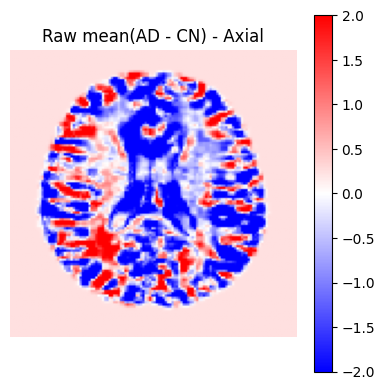

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


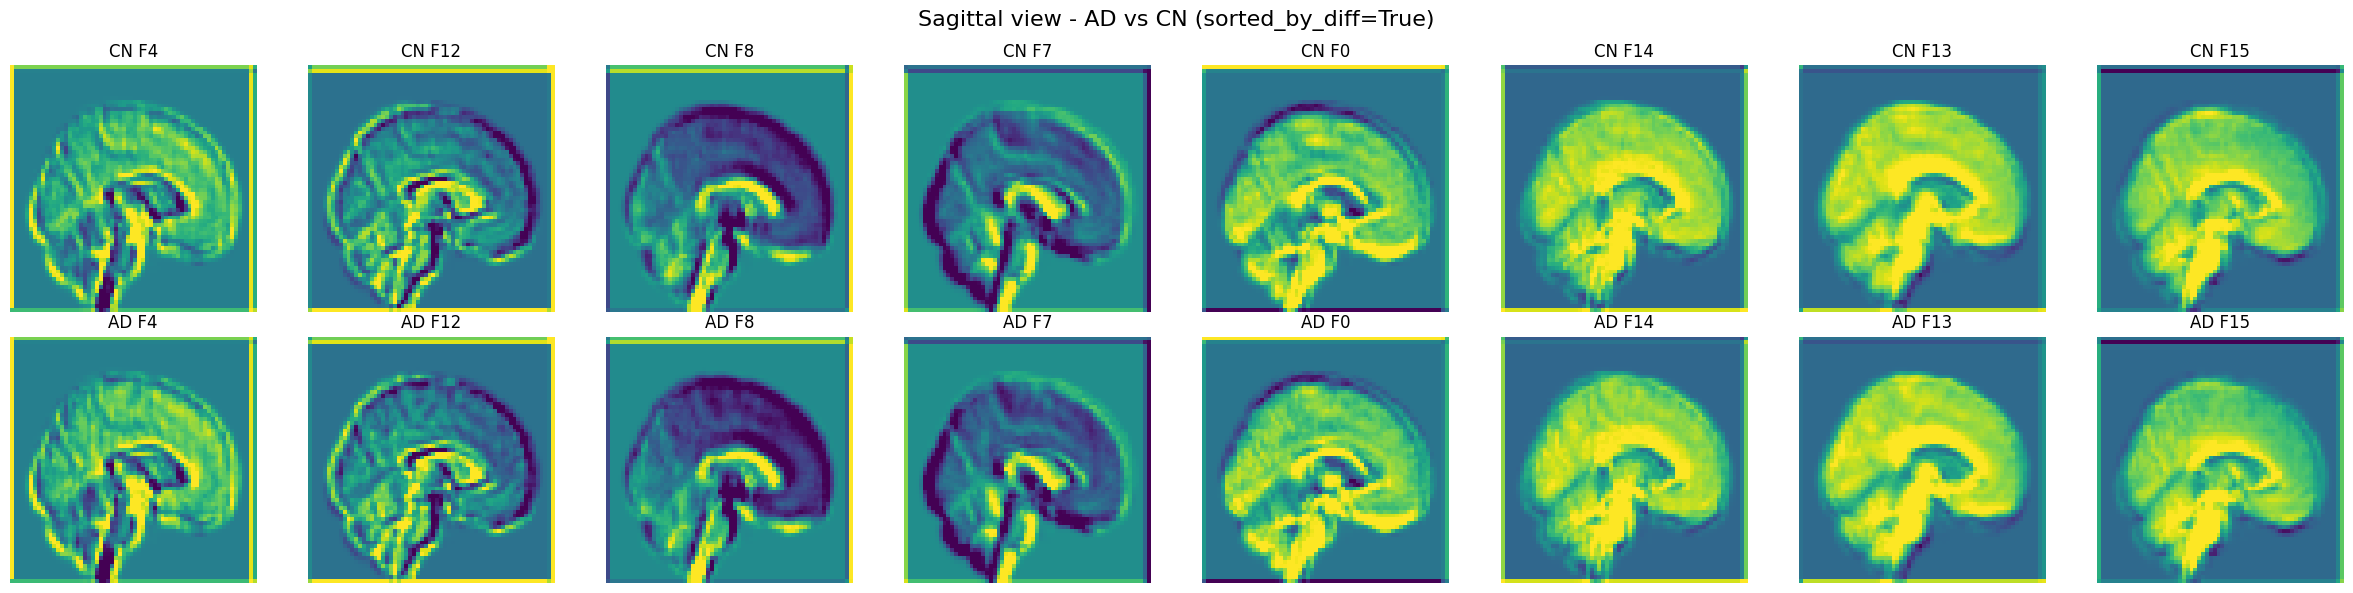

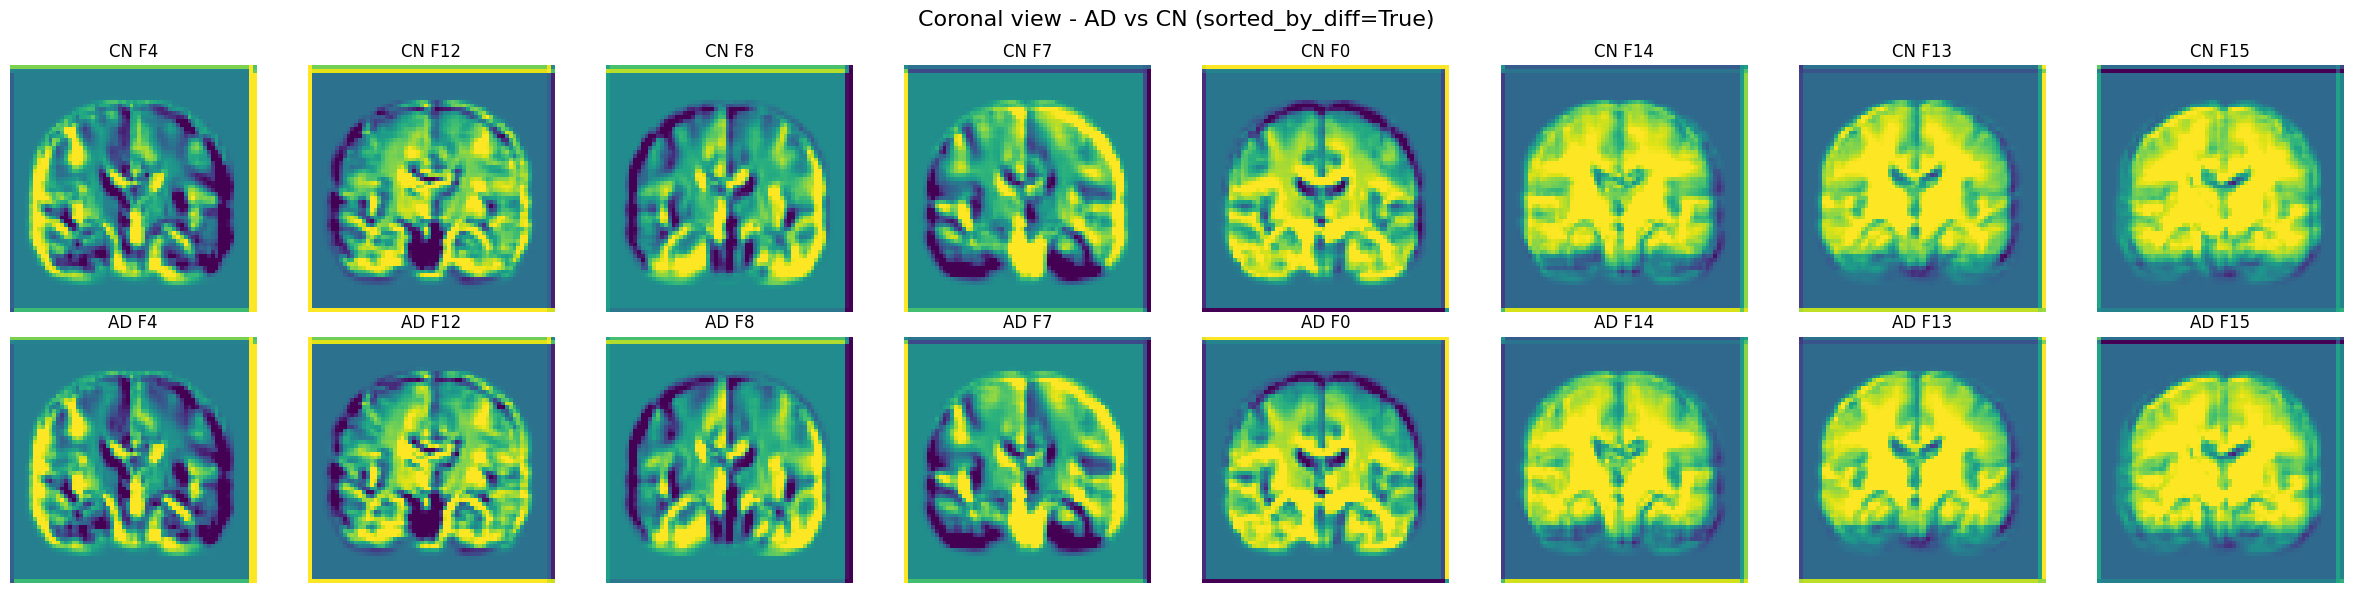

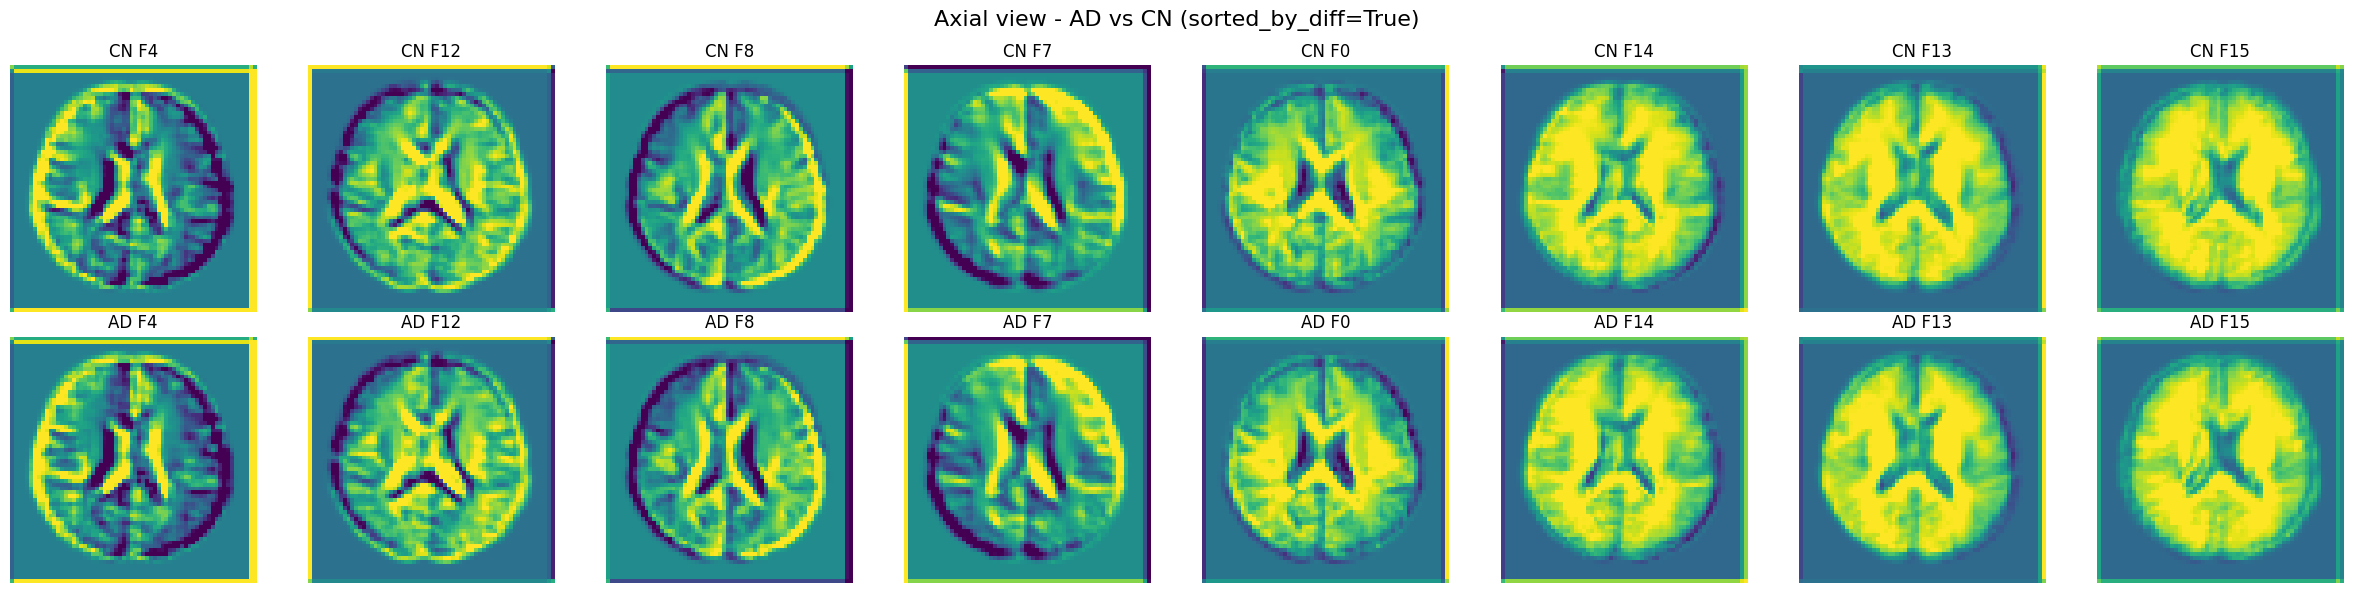

극단적인 AD 샘플 index: 69 prob: 0.9998682737350464
평범한 CN 샘플 index: 8 prob: 0.00013231622870080173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


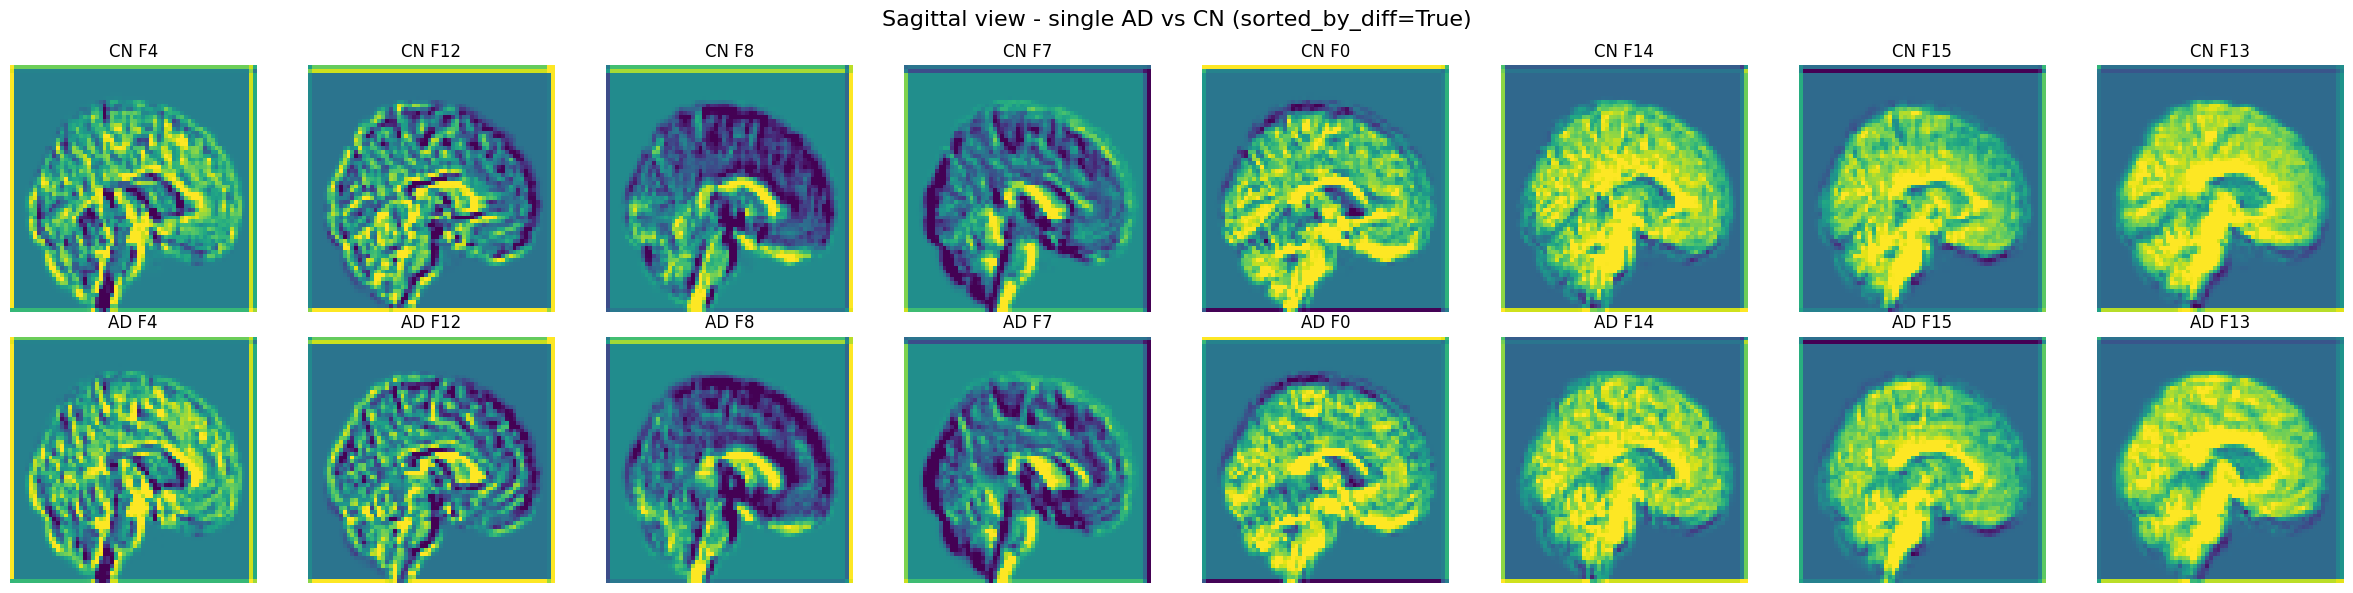

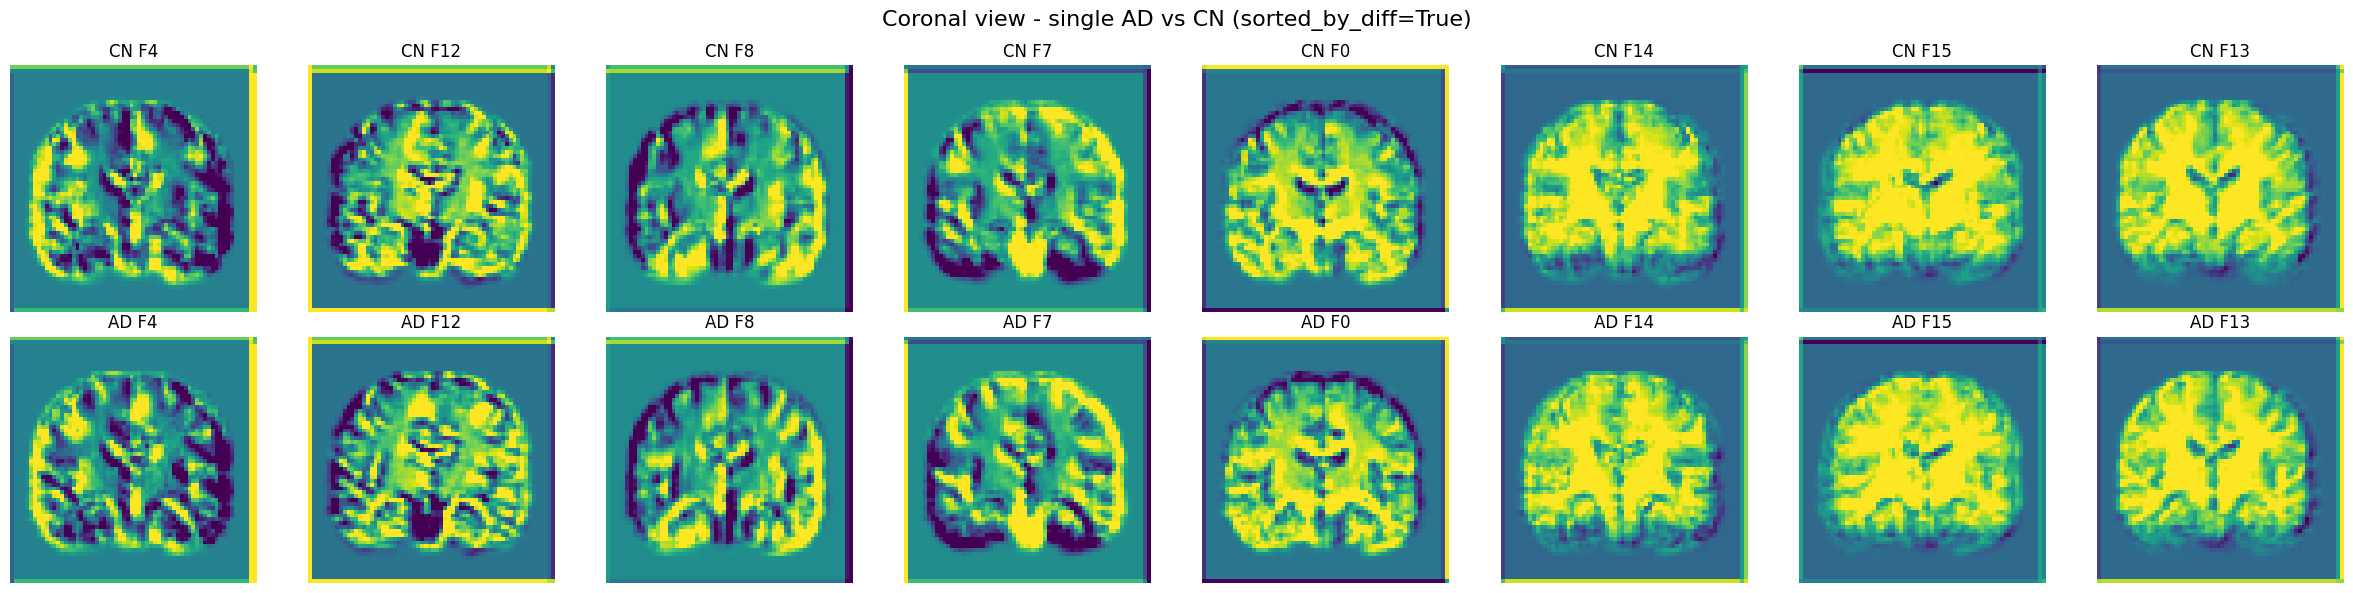

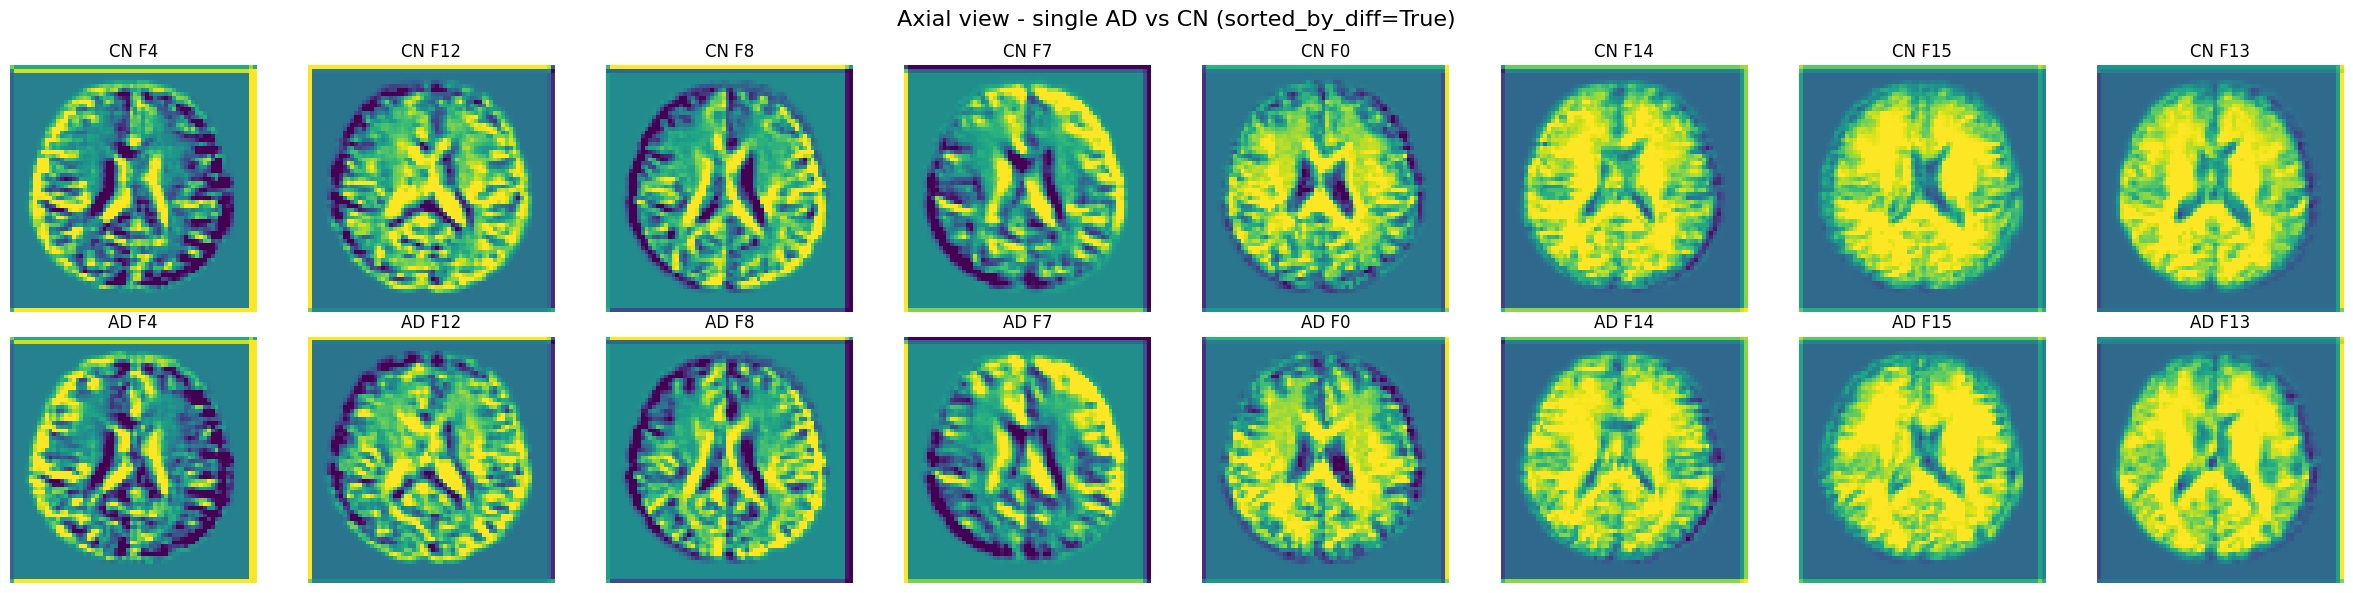

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


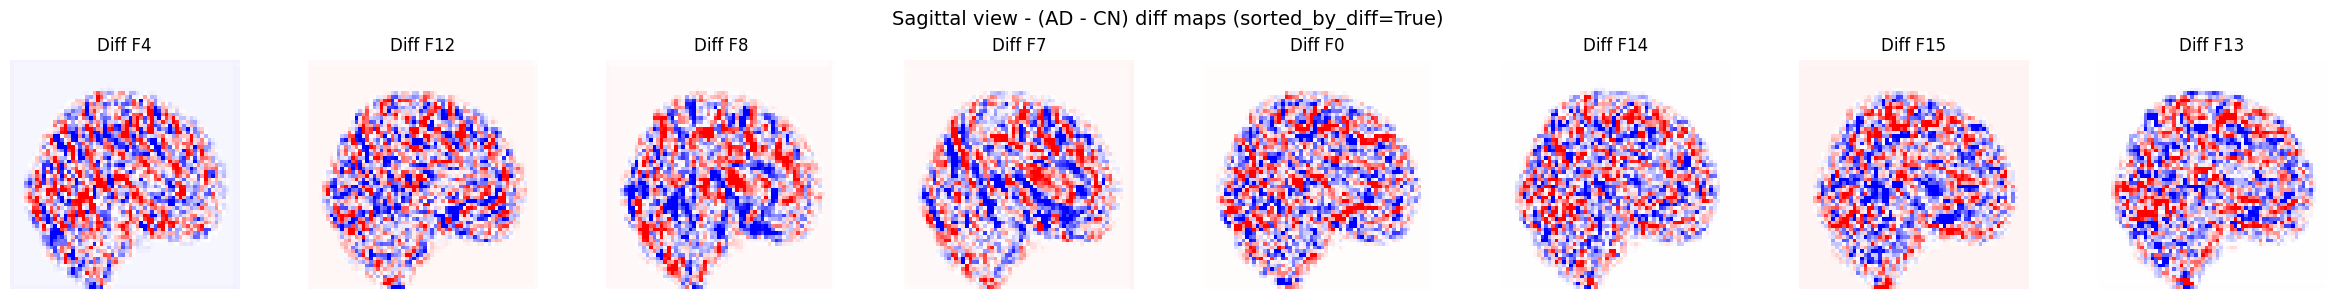

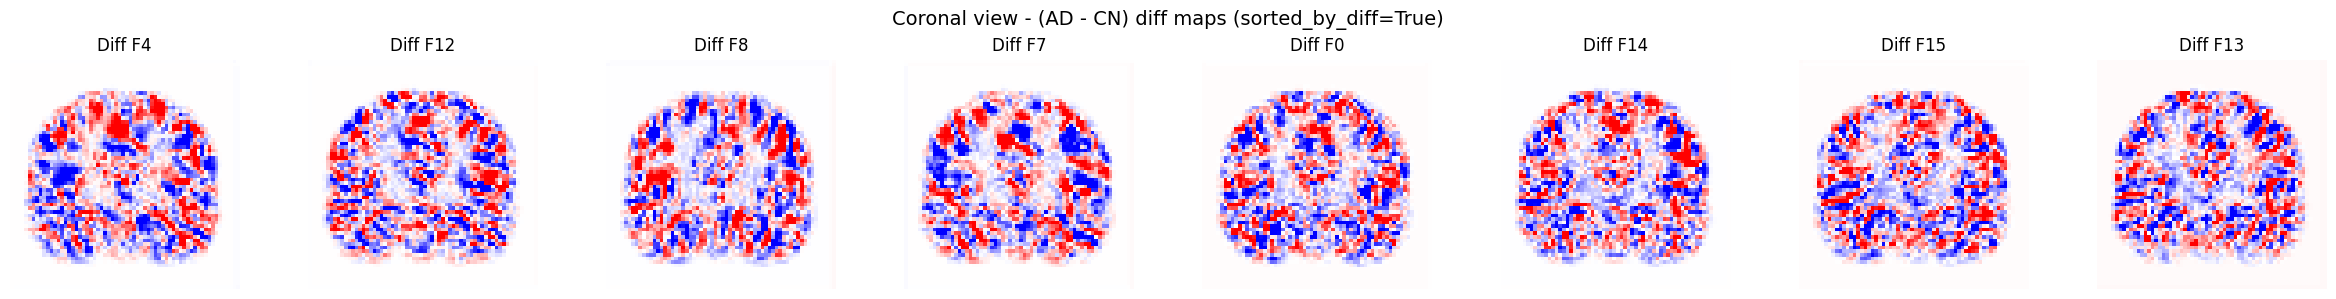

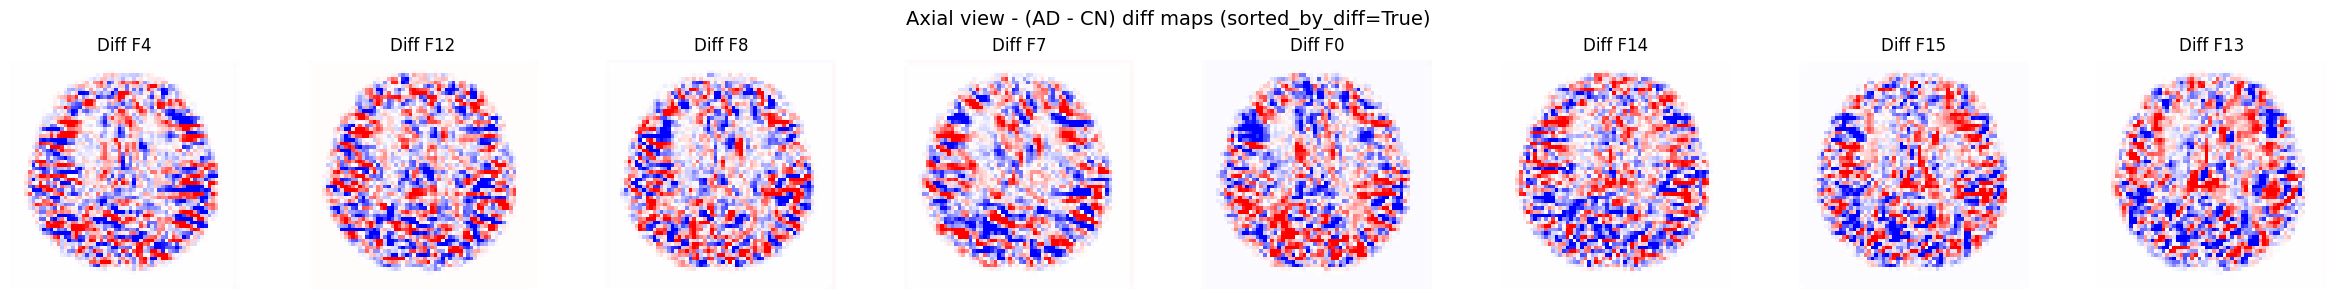

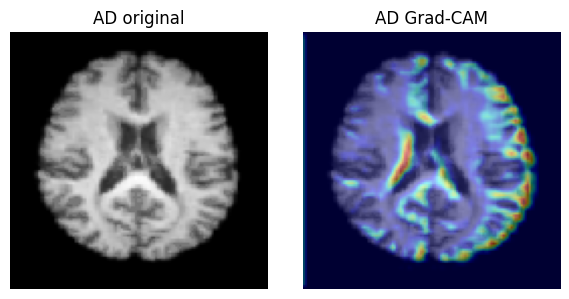

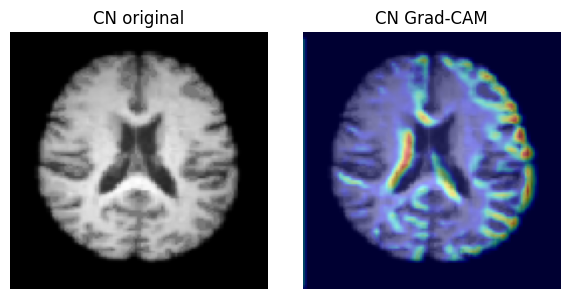

최고 기록 - threshold : 0.4
치매 : 45, 정상 : 49, 정확도 : 1.0
치매->치매 : 45, 치매->정상 : 0
정상->치매 : 0, 정상->정상 : 49
threshold : 0.00, acc : 0.48
threshold : 0.05, acc : 0.96
threshold : 0.10, acc : 0.96
threshold : 0.15, acc : 0.97
threshold : 0.20, acc : 0.98
threshold : 0.25, acc : 0.99
threshold : 0.30, acc : 0.99
threshold : 0.35, acc : 0.99
threshold : 0.40, acc : 1.00
threshold : 0.45, acc : 1.00
threshold : 0.50, acc : 1.00
threshold : 0.55, acc : 1.00
threshold : 0.60, acc : 1.00
threshold : 0.65, acc : 1.00
threshold : 0.70, acc : 1.00
threshold : 0.75, acc : 1.00
threshold : 0.80, acc : 1.00
threshold : 0.85, acc : 0.99
threshold : 0.90, acc : 0.99
threshold : 0.95, acc : 0.96


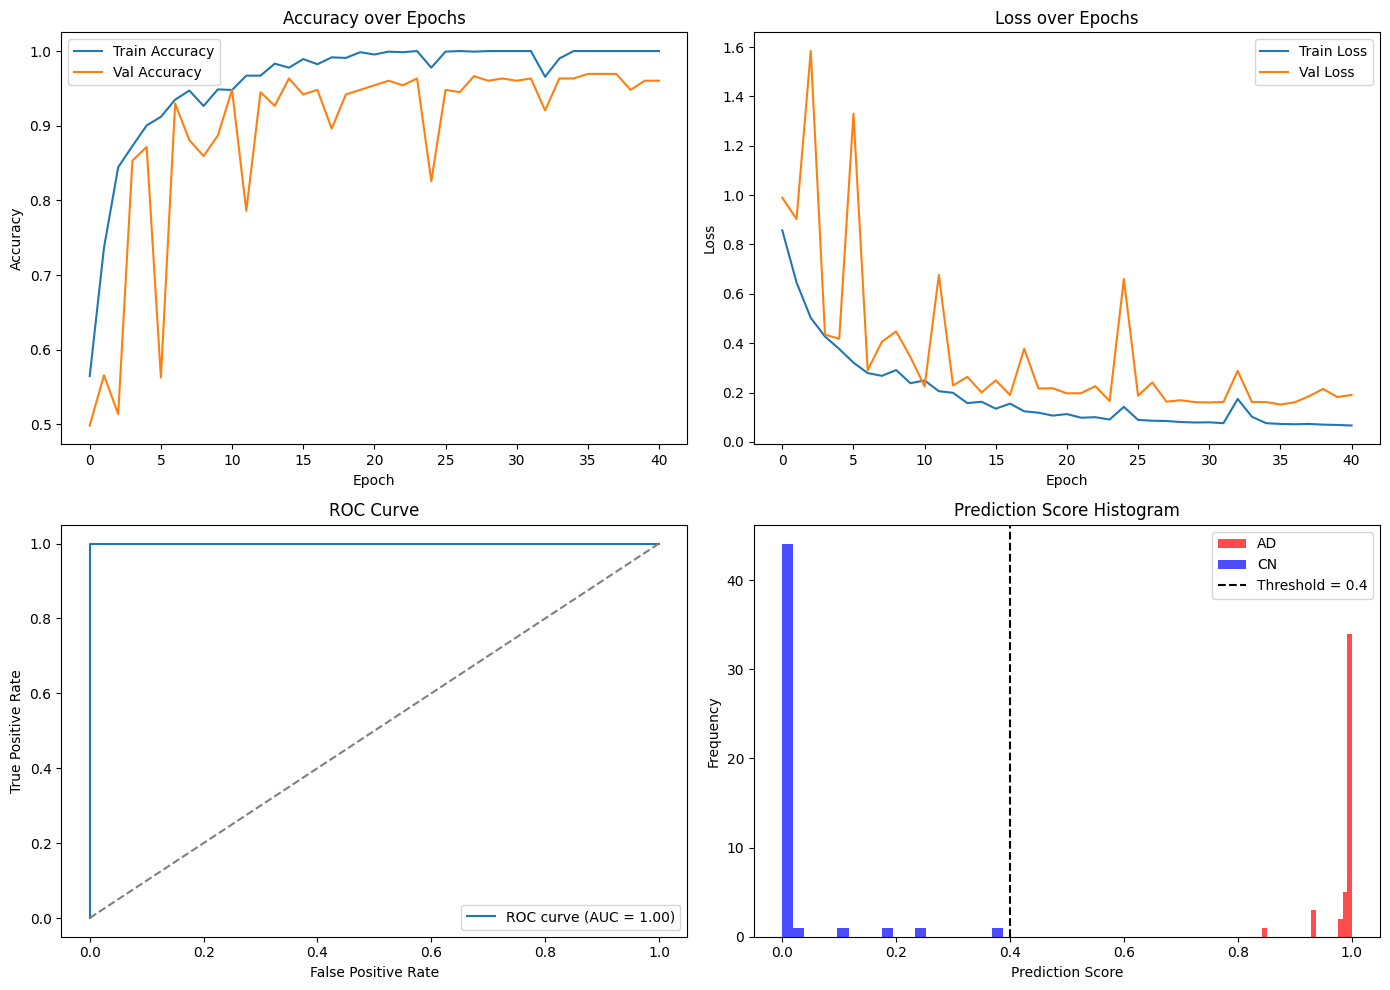

In [30]:

main()